# Flight Research and Analytics EDA

## Setup:

In [4]:
import boto3
import sagemaker
%matplotlib inline
%config InlineBackend.figure_format='retina'
#from pyathena import connect
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os 
from datetime import datetime as dt
import itertools
import time

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder, StandardScaler, Normalizer

from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, RandomizedSearchCV
from sklearn.metrics import roc_curve, auc, mean_squared_error,\
precision_score, recall_score, f1_score, accuracy_score,\
confusion_matrix, plot_confusion_matrix, classification_report
from sagemaker.tuner import HyperparameterTuner
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

#import imblearn
#from imblearn.over_sampling import RandomOverSampler
#from imblearn.under_sampling import RandomUnderSampler

sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
bucket = sagemaker_session.default_bucket()
region = boto3.Session().region_name

sm = boto3.Session().client(service_name="sagemaker", region_name=region)

## Background Business Problem Data:

In [5]:
complaints_df= pd.read_csv("s3://sagemaker-us-east-1-993410942383/content-project/airline_data/Complaints_DoTrans_data.csv")
complaints_df.head()

,Time,Cancellations,Delays,Misconnections,Fares,Reservations,Baggage,Customer_Service,Disability,Oversales,Other,Discrimination,Advertising,Animals
0,Q1_2019,359,320,138,226,419,543,329,168,75,65,27,9,1
1,Q1_2022,1220,549,208,1474,1452,1207,492,378,210,106,27,19,0


In [59]:
# find largest growth in complaints:
complaints_df['Cancellations']=complaints_df['Cancellations'].astype('float')
complaints_df['Delays']=complaints_df['Delays'].astype('float')
complaints_df['Misconnections']=complaints_df['Misconnections'].astype('float')
complaints_df['Fares']=complaints_df['Fares'].astype('float')
complaints_df['Reservations']=complaints_df['Reservations'].astype('float')
complaints_df['Baggage']=complaints_df['Baggage'].astype('float')
complaints_df['Customer_Service']=complaints_df['Customer_Service'].astype('float')
complaints_df['Disability']=complaints_df['Disability'].astype('float')
complaints_df['Oversales']=complaints_df['Oversales'].astype('float')
complaints_df['Discrimination']=complaints_df['Discrimination'].astype('float')
complaints_df['Advertising']=complaints_df['Advertising'].astype('float')
complaints_df['Animals']=complaints_df['Animals'].astype('float')
complaints_df['Other']=complaints_df['Other'].astype('float')


complaints_proportions=[]
complaints_proportions = ((complaints_df.iloc[1,1:] - complaints_df.iloc[0,1:] )/complaints_df.iloc[0,1:])*100

In [57]:
complaints_proportions

Cancellations       239.832869
Delays                 71.5625
Misconnections       50.724638
Fares               552.212389
Reservations        246.539379
Baggage              122.28361
Customer_Service     49.544073
Disability               125.0
Oversales                180.0
Other                63.076923
Discrimination             0.0
Advertising         111.111111
Animals                 -100.0
dtype: object

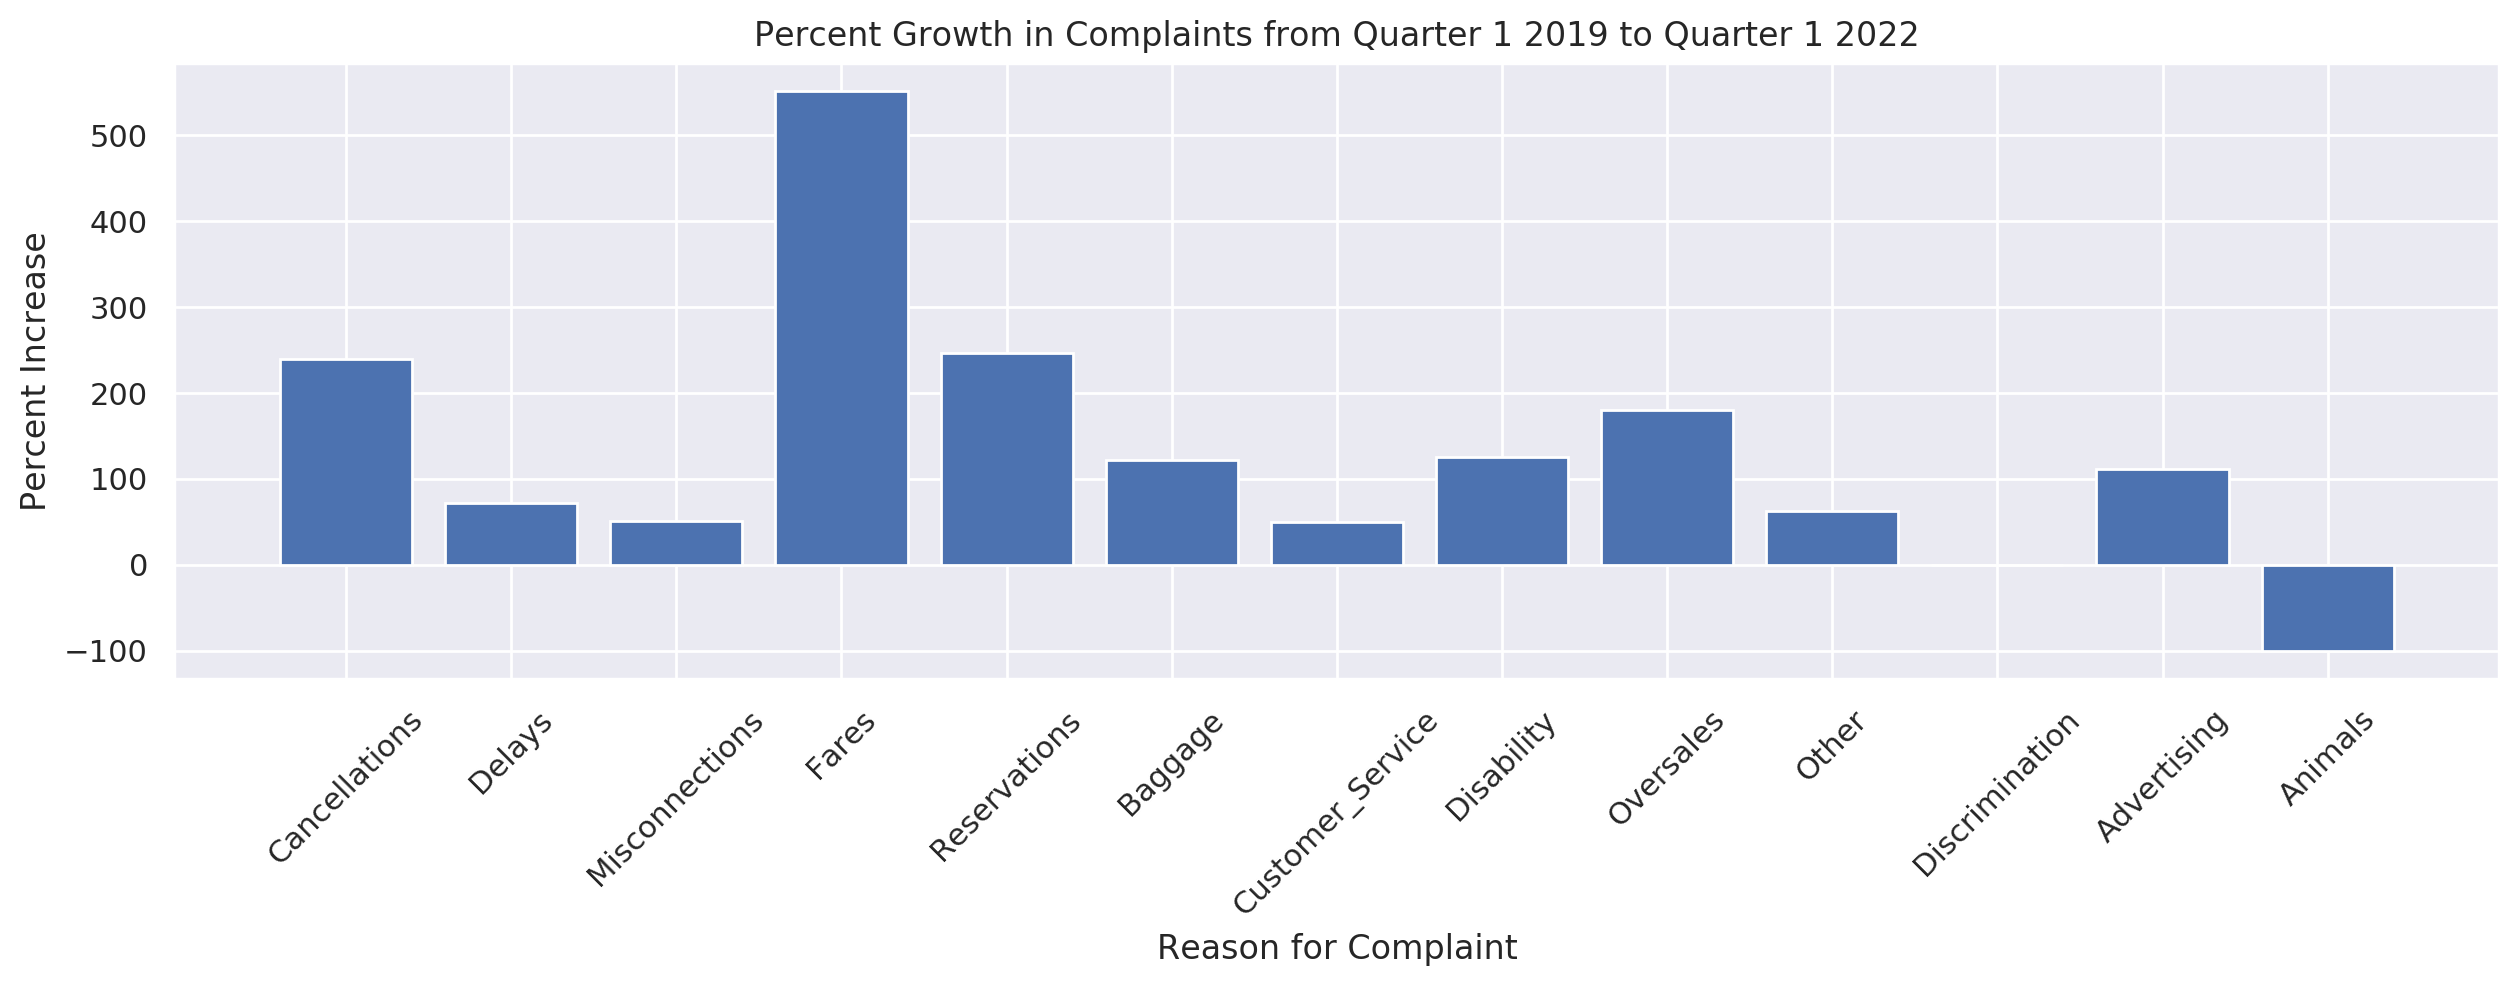

In [67]:
sns.set(rc={'figure.figsize':(15,4)})
plt.bar(x=['Cancellations','Delays','Misconnections','Fares','Reservations',
           'Baggage','Customer_Service','Disability','Oversales','Other',
           'Discrimination','Advertising','Animals'],height=complaints_proportions)
plt.title('Percent Growth in Complaints from Quarter 1 2019 to Quarter 1 2022')
plt.xlabel('Reason for Complaint')
plt.xticks(rotation=45)
plt.ylabel('Percent Increase')
plt.show()

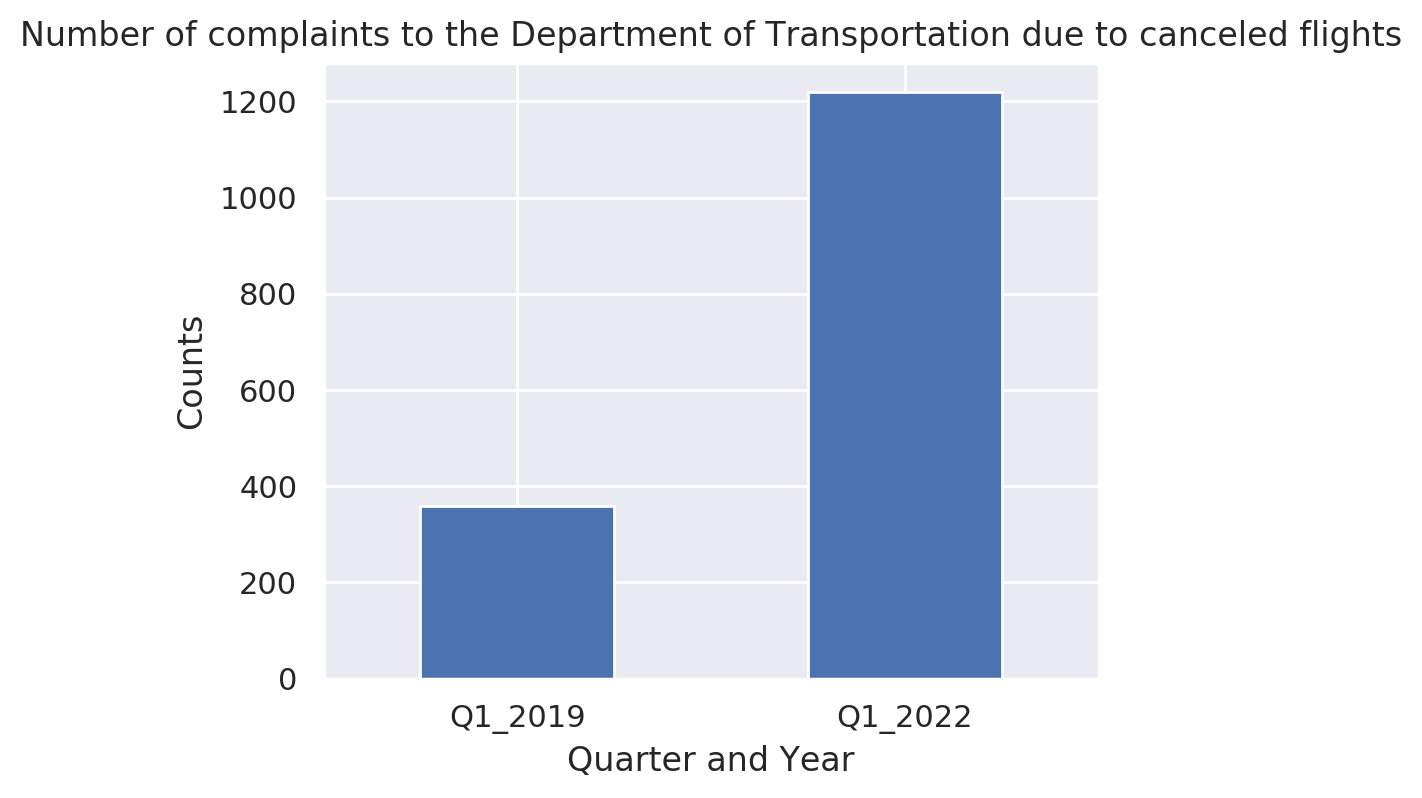

In [28]:
sns.set(rc={'figure.figsize':(5,4)})

complaints_df['Cancellations'].plot(kind='bar')
plt.title('Number of complaints to the Department of Transportation due to canceled flights')
plt.xlabel('Quarter and Year')
#.set_xticks(['Q1_2019','Q1_2022'])
plt.xticks([0,1],complaints_df['Time'], rotation=0)
plt.ylabel('Counts')
plt.show()

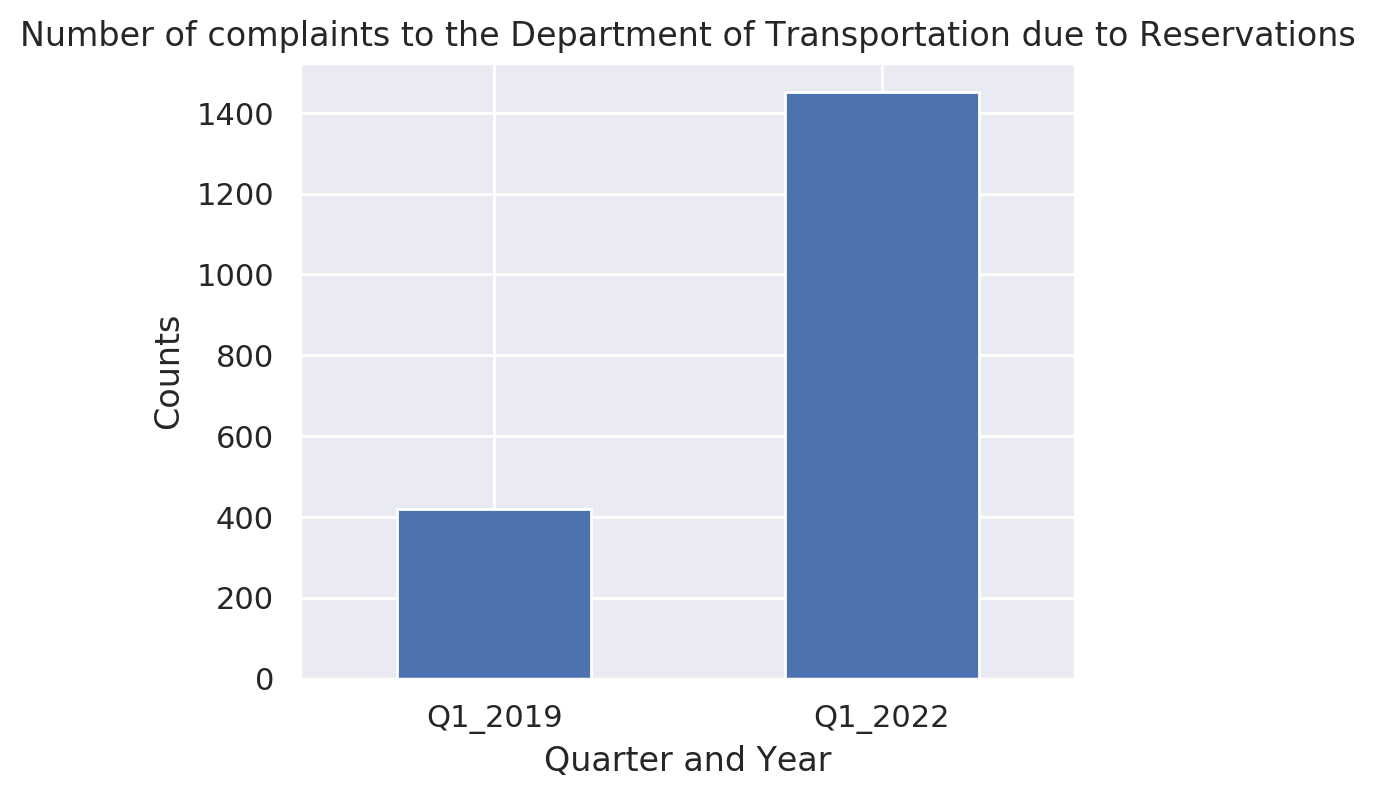

In [29]:
sns.set(rc={'figure.figsize':(5,4)})

complaints_df['Reservations'].plot(kind='bar')
plt.title('Number of complaints to the Department of Transportation due to Reservations')
plt.xlabel('Quarter and Year')
#.set_xticks(['Q1_2019','Q1_2022'])
plt.xticks([0,1],complaints_df['Time'], rotation=0)
plt.ylabel('Counts')
plt.show()

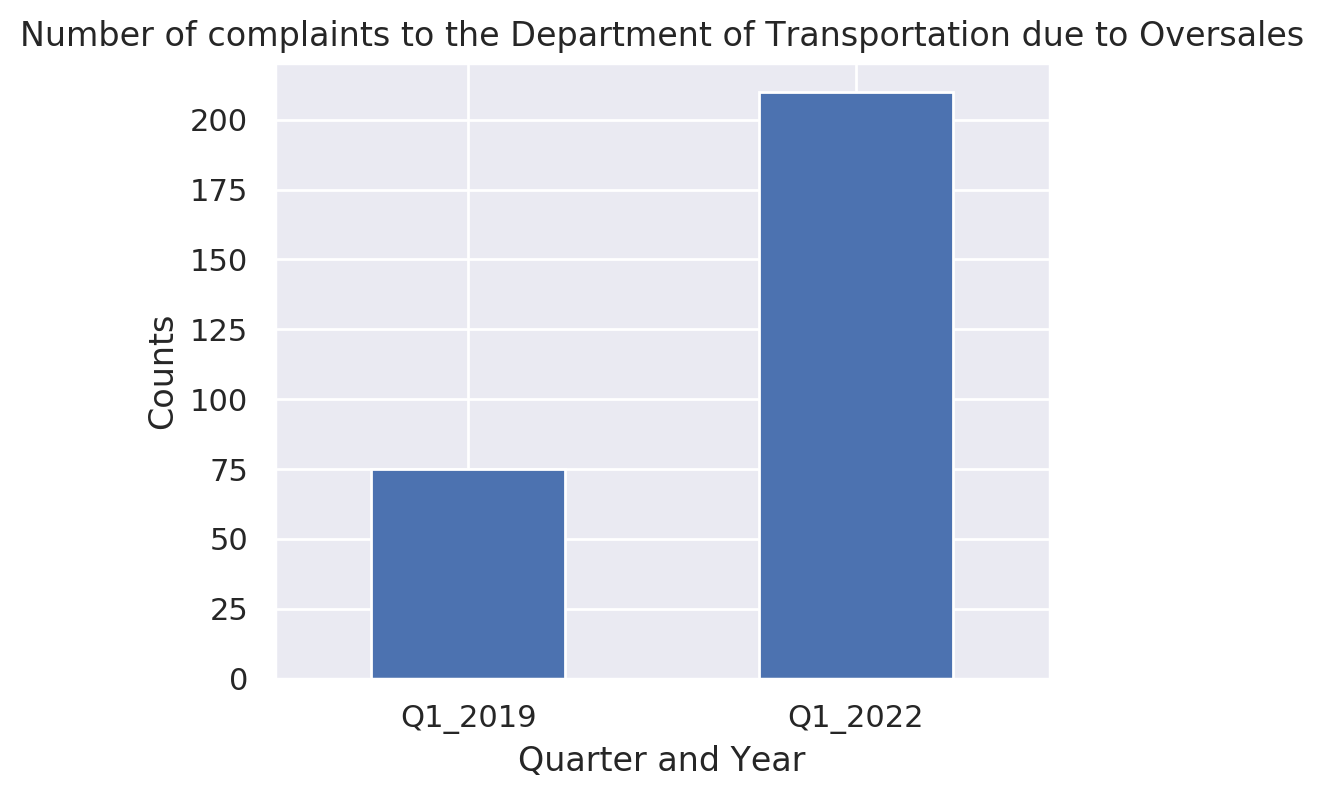

In [30]:
sns.set(rc={'figure.figsize':(5,4)})

complaints_df['Oversales'].plot(kind='bar')
plt.title('Number of complaints to the Department of Transportation due to Oversales')
plt.xlabel('Quarter and Year')
#.set_xticks(['Q1_2019','Q1_2022'])
plt.xticks([0,1],complaints_df['Time'], rotation=0)
plt.ylabel('Counts')
plt.show()

## Setup Athena:

In [3]:
!pip install --disable-pip-version-check -q PyAthena==2.1.0

In [4]:
from pyathena import connect

In [5]:
ingest_create_athena_db_passed = False

In [6]:
%store -r ingest_create_athena_table_parquet_passed

In [7]:
s3_staging_dir = "s3://{0}/athena/staging".format(bucket)

In [8]:
conn = connect(region_name=region, s3_staging_dir=s3_staging_dir)

## Dataframes:

In [3]:
weather_df= pd.read_csv("s3://sagemaker-us-east-1-993410942383/content-project/airline_data/WeatherUS_2016/WeatherUS_2016.csv")
weather_df.head()

,Unnamed: 0,EventId,Type,Severity,StartTime(UTC),EndTime(UTC),Precipitation(in),TimeZone,AirportCode,LocationLat,LocationLng,City,County,State,ZipCode
0,0,W-1,Snow,Light,2016-01-06 23:14:00,2016-01-07 00:34:00,0.00,US/Mountain,K04V,38.0972,-106.1689,Saguache,Saguache,CO,81149.0
1,1,W-2,Snow,Light,2016-01-07 04:14:00,2016-01-07 04:54:00,0.00,US/Mountain,K04V,38.0972,-106.1689,Saguache,Saguache,CO,81149.0
2,2,W-3,Snow,Light,2016-01-07 05:54:00,2016-01-07 15:34:00,0.03,US/Mountain,K04V,38.0972,-106.1689,Saguache,Saguache,CO,81149.0
3,3,W-4,Snow,Light,2016-01-08 05:34:00,2016-01-08 05:54:00,0.00,US/Mountain,K04V,38.0972,-106.1689,Saguache,Saguache,CO,81149.0
4,4,W-5,Snow,Light,2016-01-08 13:54:00,2016-01-08 15:54:00,0.00,US/Mountain,K04V,38.0972,-106.1689,Saguache,Saguache,CO,81149.0


In [68]:
flights_df= pd.read_csv("s3://sagemaker-us-east-1-993410942383/content-project/airline_data/airline_flights_table/arline_flights_table.csv")
flights_df.head()

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3553: DtypeWarning: Columns (78) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,Unnamed: 0,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,UniqueCarrier,AirlineID,Carrier,...,Div1TotalGTime,Div1LongestGTime,Div1WheelsOff,Div1TailNum,Div2Airport,Div2AirportID,Div2AirportSeqID,Div2WheelsOn,Div2TotalGTime,Div2LongestGTime
0,0,2016,1,1,6,3,2016-01-06,AA,19805,AA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2016,1,1,7,4,2016-01-07,AA,19805,AA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2016,1,1,8,5,2016-01-08,AA,19805,AA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,2016,1,1,9,6,2016-01-09,AA,19805,AA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,2016,1,1,10,7,2016-01-10,AA,19805,AA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
CancellationCode_df= pd.read_csv("s3://sagemaker-us-east-1-993410942383/content-project/airline_data/cancellation_table/CancellationCode_table.csv")
CancellationCode_df.head()

,Unnamed: 0,Code,Description
0,0,A,Carrier
1,1,B,Weather
2,2,C,National Air System
3,3,D,Security


In [11]:
AirportCodes_df= pd.read_csv("s3://sagemaker-us-east-1-993410942383/content-project/airline_data/airport_codes_table/airport_codes_table.csv")
AirportCodes_df.head()

,Unnamed: 0,Code,Description
0,0,01A,"Afognak Lake, AK: Afognak Lake Airport"
1,1,03A,"Granite Mountain, AK: Bear Creek Mining Strip"
2,2,04A,"Lik, AK: Lik Mining Camp"
3,3,05A,"Little Squaw, AK: Little Squaw Airport"
4,4,06A,"Kizhuyak, AK: Kizhuyak Bay"


In [12]:
JFK_weather_data= pd.read_csv("s3://sagemaker-us-east-1-993410942383/content-project/airline_data/JFK_weather/JFK_weather_Jan_2016.csv")

## Data Clean/Prep

prepare data so flights can be matched up to proper weather data:

In [40]:
# remove prefix K on airport codes so we can match them 
# to flight data:

weather_df['AirportCode'] = weather_df['AirportCode'].str[1:]


In [17]:
# Prepare flights data for datetime (timestamp) format
# by changing the type of CRSDepTime from int to string:

flights_df['CRSDepTime'] = flights_df['CRSDepTime'].astype('string')


In [41]:
# rename weather data 2016 start and end datetimes:

weather_df.rename(columns={'StartTime(UTC)':'StartTime'}, inplace=True)
weather_df.rename(columns={'EndTime(UTC)':'EndTime'}, inplace=True)


In [42]:
weather_df.head()

,Unnamed: 0,EventId,Type,Severity,StartTime,EndTime,Precipitation(in),TimeZone,AirportCode,LocationLat,LocationLng,City,County,State,ZipCode
0,0,W-1,Snow,Light,2016-01-06 23:14:00,2016-01-07 00:34:00,0.00,US/Mountain,04V,38.0972,-106.1689,Saguache,Saguache,CO,81149.0
1,1,W-2,Snow,Light,2016-01-07 04:14:00,2016-01-07 04:54:00,0.00,US/Mountain,04V,38.0972,-106.1689,Saguache,Saguache,CO,81149.0
2,2,W-3,Snow,Light,2016-01-07 05:54:00,2016-01-07 15:34:00,0.03,US/Mountain,04V,38.0972,-106.1689,Saguache,Saguache,CO,81149.0
3,3,W-4,Snow,Light,2016-01-08 05:34:00,2016-01-08 05:54:00,0.00,US/Mountain,04V,38.0972,-106.1689,Saguache,Saguache,CO,81149.0
4,4,W-5,Snow,Light,2016-01-08 13:54:00,2016-01-08 15:54:00,0.00,US/Mountain,04V,38.0972,-106.1689,Saguache,Saguache,CO,81149.0


In [20]:
# Clean up weather for JFK data where there is a T that stands for "trace":

JFK_weather_data['Precipitation']=JFK_weather_data['Precipitation'].replace(['T'], 0.0001)
JFK_weather_data['Snow_Depth']=JFK_weather_data['Snow_Depth'].replace(['T'], 0.0001)
JFK_weather_data['New_Snow']=JFK_weather_data['New_Snow'].replace(['T'], 0.0001)

In [21]:
# Drop the last rows that give
# summary statistics:

JFK_weather_data.drop(JFK_weather_data.tail(3).index,inplace=True)


In [22]:
# convert the Date column into the
# proper format:

JFK_weather_data['Date'] = pd.to_datetime(JFK_weather_data['Date'], 
                                          format='%m/%d/%Y').dt.date
#convert date to YYYYMMDD format


In [23]:
JFK_weather_data.head(31)

,Date,MaxTemp,MinTemp,AvgTemp,DepTemp,HDD,CDD,Precipitation,New_Snow,Snow_Depth
0,2016-01-01,44.0,36.0,40,5.4,25,0,0,0,0
1,2016-01-02,41.0,34.0,37.5,3.1,27,0,0,0,0
2,2016-01-03,48.0,35.0,41.5,7.3,23,0,0,0,0
3,2016-01-04,38.0,15.0,26.5,-7.5,38,0,0,0,0
4,2016-01-05,29.0,12.0,20.5,-13.4,44,0,0,0,0
5,2016-01-06,40.0,21.0,30.5,-3.2,34,0,0,0,0
6,2016-01-07,46.0,27.0,36.5,3,28,0,0,0,0
7,2016-01-08,47.0,32.0,39.5,6.1,25,0,0,0,0
8,2016-01-09,53.0,40.0,46.5,13.3,18,0,0.02,0,0
9,2016-01-10,58.0,41.0,49.5,16.4,15,0,1.28,0,0


### For the JFK flights only:

In [24]:
# Checking the class balance on our target variable 'Cancelled' as cancelled fllights
dff_Origin_JFK = flights_df[flights_df["Origin"]=="JFK"].reset_index()
#data[data['Value'] == True]
dff_Origin_JFK.head()


,index,Unnamed: 0,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,UniqueCarrier,AirlineID,...,Div1TotalGTime,Div1LongestGTime,Div1WheelsOff,Div1TailNum,Div2Airport,Div2AirportID,Div2AirportSeqID,Div2WheelsOn,Div2TotalGTime,Div2LongestGTime
0,88,88,2016,1,1,1,5,2016-01-01,AA,19805,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,89,89,2016,1,1,2,6,2016-01-02,AA,19805,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,90,90,2016,1,1,3,7,2016-01-03,AA,19805,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,91,91,2016,1,1,4,1,2016-01-04,AA,19805,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,92,92,2016,1,1,5,2,2016-01-05,AA,19805,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
# Fill CRSDepTime with the right amount of zeros to the left and right
# depending on the original length of the field:

for x in range(0,len(dff_Origin_JFK)):
#for x in range(0,5):
    if len(dff_Origin_JFK.loc[x,'CRSDepTime']) == 4:
        dff_Origin_JFK.loc[x,'CRSDepTime']=dff_Origin_JFK.loc[x,'CRSDepTime'].ljust(6,'0')
    if len(dff_Origin_JFK.loc[x,'CRSDepTime']) == 2:
        dff_Origin_JFK.loc[x,'CRSDepTime']=dff_Origin_JFK.loc[x,'CRSDepTime'].ljust(4,'0')
        dff_Origin_JFK.loc[x,'CRSDepTime']=dff_Origin_JFK.loc[x,'CRSDepTime'].rjust(6,'0')
    else:
        dff_Origin_JFK.loc[x,'CRSDepTime']=dff_Origin_JFK.loc[x,'CRSDepTime'].ljust(5,'0')
        dff_Origin_JFK.loc[x,'CRSDepTime']=dff_Origin_JFK.loc[x,'CRSDepTime'].rjust(6,'0')



In [26]:
for x in range(len(dff_Origin_JFK)):
    dff_Origin_JFK.loc[x,'CRSDepTime']=pd.to_datetime(dff_Origin_JFK.loc[x,'CRSDepTime'], format='%H%M%S').strftime('%H:%M:%S')


In [27]:
dff_Origin_JFK['FlightDate'] = dff_Origin_JFK['FlightDate'].astype(str) + ' ' + dff_Origin_JFK['CRSDepTime'].astype(str) 


In [28]:
dff_Origin_JFK.drop(['Unnamed: 0'],axis=1,inplace=True)

In [31]:
dff_Origin_JFK.head()

,index,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,UniqueCarrier,AirlineID,Carrier,...,Div1TotalGTime,Div1LongestGTime,Div1WheelsOff,Div1TailNum,Div2Airport,Div2AirportID,Div2AirportSeqID,Div2WheelsOn,Div2TotalGTime,Div2LongestGTime
0,88,2016,1,1,1,5,2016-01-01 18:25:00,AA,19805,AA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,89,2016,1,1,2,6,2016-01-02 18:25:00,AA,19805,AA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,90,2016,1,1,3,7,2016-01-03 18:25:00,AA,19805,AA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,91,2016,1,1,4,1,2016-01-04 18:25:00,AA,19805,AA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,92,2016,1,1,5,2,2016-01-05 18:20:00,AA,19805,AA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
dff_Origin_JFK['FlightDate'] = pd.to_datetime(dff_Origin_JFK['FlightDate'], 
                                          format='%Y-%m-%d %H:%M:%S')

In [168]:
dff_Origin_JFK_mod=dff_Origin_JFK.copy()
dff_Origin_JFK_mod['FlightDate']=dff_Origin_JFK_mod['FlightDate'].dt.date

In [218]:
dff_Origin_JFK_mod.head()

,index,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,UniqueCarrier,AirlineID,Carrier,...,Div1TotalGTime,Div1LongestGTime,Div1WheelsOff,Div1TailNum,Div2Airport,Div2AirportID,Div2AirportSeqID,Div2WheelsOn,Div2TotalGTime,Div2LongestGTime
0,88,2016,1,1,1,5,2016-01-01,AA,19805,AA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,89,2016,1,1,2,6,2016-01-02,AA,19805,AA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,90,2016,1,1,3,7,2016-01-03,AA,19805,AA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,91,2016,1,1,4,1,2016-01-04,AA,19805,AA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,92,2016,1,1,5,2,2016-01-05,AA,19805,AA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### For the entire flights dataframe:

In [399]:
# Fill CRSDepTime with the right amount of zeros to the left and right
# depending on the original length of the field:

#for x in range(0,len(flights_df)):
#    if len(flights_df.loc[x,'CRSDepTime']) == 4:
#        flights_df.loc[x,'CRSDepTime']=flights_df.loc[x,'CRSDepTime'].ljust(6,'0')
#    if len(flights_df.loc[x,'CRSDepTime']) == 2:
#        flights_df.loc[x,'CRSDepTime']=flights_df.loc[x,'CRSDepTime'].ljust(4,'0')
#        flights_df.loc[x,'CRSDepTime']=flights_df.loc[x,'CRSDepTime'].rjust(6,'0')
#    else:
#        flights_df.loc[x,'CRSDepTime']=flights_df.loc[x,'CRSDepTime'].ljust(5,'0')
#        flights_df.loc[x,'CRSDepTime']=flights_df.loc[x,'CRSDepTime'].rjust(6,'0')



In [ ]:
#for x in range(len(flights_df)):
#    flights_df.loc[x,'CRSDepTime']=pd.to_datetime(flights_df.loc[x,'CRSDepTime'], format='%H%M%S').strftime('%H:%M:%S')


In [ ]:
#flights_df['FlightDate'] = flights_df['FlightDate'].astype(str) + ' ' + flights_df['CRSDepTime'].astype(str) 


### airport codes dataframe cleanup:

In [32]:
# Split up the "Description" field in the original aiport dataframe
# So that fields mean something more - the airport code is followed by
# the related airport name and it's city and state:

AirportCodes_df[['City_State', 'Airport']] = AirportCodes_df['Description'].str.split(':', expand=True)
AirportCodes_df= AirportCodes_df.drop('Description', axis=1)
AirportCodes_df[['City', 'State']] = AirportCodes_df['City_State'].str.split(',', n=1, expand=True)
AirportCodes_df= AirportCodes_df.drop('City_State', axis=1)


In [33]:
AirportCodes_df['City']=AirportCodes_df['City'].astype('string')
AirportCodes_df['Airport']=AirportCodes_df['Airport'].astype('string')
AirportCodes_df['State']=AirportCodes_df['State'].astype('string')
AirportCodes_df['Code']=AirportCodes_df['Code'].astype('string')

In [34]:
AirportCodes_df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [35]:
AirportCodes_df.head()

,Code,Airport,City,State
0,01A,Afognak Lake Airport,Afognak Lake,AK
1,03A,Bear Creek Mining Strip,Granite Mountain,AK
2,04A,Lik Mining Camp,Lik,AK
3,05A,Little Squaw Airport,Little Squaw,AK
4,06A,Kizhuyak Bay,Kizhuyak,AK


### Obtain subsets of cleaner weather_2016 data for JFK only:

In [43]:
# Checking the class balance on our target variable 'Cancelled' as cancelled fllights
dff_Weather_JFK = weather_df[weather_df["AirportCode"]=="JFK"].reset_index()
#data[data['Value'] == True]
dff_Weather_JFK.head()

,index,Unnamed: 0,EventId,Type,Severity,StartTime,EndTime,Precipitation(in),TimeZone,AirportCode,LocationLat,LocationLng,City,County,State,ZipCode
0,52242,335383,W-340157,Rain,Light,2016-01-10 03:51:00,2016-01-10 06:51:00,0.01,US/Eastern,JFK,40.6392,-73.7639,Jamaica,Queens,NY,11430.0
1,52243,335384,W-340158,Rain,Light,2016-01-10 08:51:00,2016-01-10 09:51:00,0.05,US/Eastern,JFK,40.6392,-73.7639,Jamaica,Queens,NY,11430.0
2,52244,335385,W-340159,Rain,Moderate,2016-01-10 09:51:00,2016-01-10 10:51:00,0.25,US/Eastern,JFK,40.6392,-73.7639,Jamaica,Queens,NY,11430.0
3,52245,335386,W-340160,Rain,Heavy,2016-01-10 10:51:00,2016-01-10 11:33:00,0.31,US/Eastern,JFK,40.6392,-73.7639,Jamaica,Queens,NY,11430.0
4,52246,335387,W-340161,Rain,Moderate,2016-01-10 11:33:00,2016-01-10 14:51:00,0.84,US/Eastern,JFK,40.6392,-73.7639,Jamaica,Queens,NY,11430.0


In [363]:
dff_Weather_Jan = weather_df[weather_df["StartTime"].dt.month == 1].reset_index()
#data[data['Value'] == True]
dff_Weather_Jan.head()

,index,Type,Severity,StartTime,EndTime,Precipitation(in),TimeZone,AirportCode,LocationLat,LocationLng,City,County,State,ZipCode
0,0,Snow,Light,2016-01-06 23:14:00,2016-01-07 00:34:00,0.00,US/Mountain,04V,38.0972,-106.1689,Saguache,Saguache,CO,81149.0
1,1,Snow,Light,2016-01-07 04:14:00,2016-01-07 04:54:00,0.00,US/Mountain,04V,38.0972,-106.1689,Saguache,Saguache,CO,81149.0
2,2,Snow,Light,2016-01-07 05:54:00,2016-01-07 15:34:00,0.03,US/Mountain,04V,38.0972,-106.1689,Saguache,Saguache,CO,81149.0
3,3,Snow,Light,2016-01-08 05:34:00,2016-01-08 05:54:00,0.00,US/Mountain,04V,38.0972,-106.1689,Saguache,Saguache,CO,81149.0
4,4,Snow,Light,2016-01-08 13:54:00,2016-01-08 15:54:00,0.00,US/Mountain,04V,38.0972,-106.1689,Saguache,Saguache,CO,81149.0


## Feature engineering:

In [44]:
# Find all possible unique values for weather type
# and weather severity in the weather dataframe:

Type_unique=weather_df['Type'].unique()
Severity_unique=weather_df['Severity'].unique()


In [45]:
# Generate all possible combinations for weather
# type and severity so that we assign a code called weather_code
# This feature can be used by data science teams to see if there is a
# relationship with cancellations and the combination of such 
# weather conditions:

all_combinations = list(itertools.product(Type_unique, Severity_unique))
Weather_comb_var = pd.DataFrame(all_combinations, columns=['Type','Severity'])

### Add new feature to weather_2016 JFK data:

In [46]:
# For JFK location ONLY:

weather_code = []

for i in dff_Weather_JFK.index:
    for x in Weather_comb_var.index:
        if (dff_Weather_JFK.loc[i, 'Type'] == Weather_comb_var.loc[x,'Type']) & (dff_Weather_JFK.loc[i, 'Severity'] == Weather_comb_var.loc[x,'Severity']):
            weather_code.append(x)
 
dff_Weather_JFK['Weather_Comb_Var'] = weather_code

In [47]:
dff_Weather_JFK.drop(["Unnamed: 0","EventId"], axis=1, inplace=True)

In [266]:
dff_Weather_JFK['StartTime'] = pd.to_datetime(dff_Weather_JFK['StartTime'], 
                                          format='%Y-%m-%d %H:%M:%S')
dff_Weather_JFK['EndTime'] = pd.to_datetime(dff_Weather_JFK['EndTime'], 
                                          format='%Y-%m-%d %H:%M:%S')

In [356]:
dff_Weather_JFK.head(20)

,index,Type,Severity,StartTime,EndTime,Precipitation(in),TimeZone,AirportCode,LocationLat,LocationLng,City,County,State,ZipCode,Weather_Comb_Var
0,52242,Rain,Light,2016-01-10 03:51:00,2016-01-10 06:51:00,0.01,US/Eastern,JFK,40.6392,-73.7639,Jamaica,Queens,NY,11430.0,24
1,52243,Rain,Light,2016-01-10 08:51:00,2016-01-10 09:51:00,0.05,US/Eastern,JFK,40.6392,-73.7639,Jamaica,Queens,NY,11430.0,24
2,52244,Rain,Moderate,2016-01-10 09:51:00,2016-01-10 10:51:00,0.25,US/Eastern,JFK,40.6392,-73.7639,Jamaica,Queens,NY,11430.0,26
3,52245,Rain,Heavy,2016-01-10 10:51:00,2016-01-10 11:33:00,0.31,US/Eastern,JFK,40.6392,-73.7639,Jamaica,Queens,NY,11430.0,27
4,52246,Rain,Moderate,2016-01-10 11:33:00,2016-01-10 14:51:00,0.84,US/Eastern,JFK,40.6392,-73.7639,Jamaica,Queens,NY,11430.0,26
5,52247,Fog,Severe,2016-01-10 16:51:00,2016-01-10 21:26:00,0.00,US/Eastern,JFK,40.6392,-73.7639,Jamaica,Queens,NY,11430.0,7
6,52248,Rain,Light,2016-01-10 21:26:00,2016-01-10 22:11:00,0.05,US/Eastern,JFK,40.6392,-73.7639,Jamaica,Queens,NY,11430.0,24
7,52249,Rain,Light,2016-01-10 22:51:00,2016-01-10 23:51:00,0.01,US/Eastern,JFK,40.6392,-73.7639,Jamaica,Queens,NY,11430.0,24
8,52250,Rain,Light,2016-01-12 21:51:00,2016-01-12 22:51:00,0.00,US/Eastern,JFK,40.6392,-73.7639,Jamaica,Queens,NY,11430.0,24
9,52251,Snow,Light,2016-01-14 10:51:00,2016-01-14 11:51:00,0.00,US/Eastern,JFK,40.6392,-73.7639,Jamaica,Queens,NY,11430.0,0


### for entire weatherUS 2016:

In [381]:
# Took too long:

#weather_code2 = []

#for i in weather_df.index:
#    for x in Weather_comb_var.index:
#        if (weather_df.loc[i, 'Type'] == Weather_comb_var.loc[x,'Type']) & (weather_df.loc[i, 'Severity'] == Weather_comb_var.loc[x,'Severity']):
#            weather_code2.append(x)
 
#weather_df['Weather_Comb_Var'] = weather_code2

In [323]:
weather_df.drop(["Unnamed: 0","EventId"], axis=1, inplace=True)

In [324]:
weather_df['StartTime'] = pd.to_datetime(weather_df['StartTime'], 
                                          format='%Y-%m-%d %H:%M:%S')
weather_df['EndTime'] = pd.to_datetime(weather_df['EndTime'], 
                                          format='%Y-%m-%d %H:%M:%S')

### check sizes of dataframes:

In [213]:
dff_Weather_JFK.shape

(443, 15)

In [214]:
dff_Origin_JFK.shape

(8027, 84)

In [65]:
Weather_comb_var.head()

,Type,Severity
0,Snow,Light
1,Snow,Severe
2,Snow,Moderate
3,Snow,Heavy
4,Snow,UNK


## Combine features of interest:

### Select Flight and WeatherUS_2016 features:

In [365]:
# Grap only the columns of interest from JFK flights data:
JFK_Flights_FS = dff_Origin_JFK.copy()
JFK_Flights_FS = JFK_Flights_FS[["FlightDate",
                                "DayOfWeek",
                                "AirlineID",
                                "Origin",
                                "Dest",
                                "WeatherDelay", 
                                "CancellationCode",
                                "Cancelled"]]


In [366]:
# Pre-assign weather type/severity conditions
# as fair before modifying based on the watherUS_2016 data
# if the combination variable is 99, the weather was fair and normal:

JFK_Flights_FS['Origin_Weather_Type'] = 'Fair'
JFK_Flights_FS['Origin_Weather_Severity'] = 'Normal'
JFK_Flights_FS['Origin_Weather_Comb'] = 99
JFK_Flights_FS['Origin_Weather_Precipitation'] = 0.0
JFK_Flights_FS['Dest_Weather_Type'] = 'Fair'
JFK_Flights_FS['Dest_Weather_Severity'] = 'Normal'
JFK_Flights_FS['Dest_Weather_Comb'] = 99
JFK_Flights_FS['Dest_Weather_Precipitation'] = 0.0


In [367]:
# If the flight is not canceled, the code is 'Z':

JFK_Flights_FS['CancellationCode'].replace(np.nan, value='Z', inplace = True)
JFK_Flights_FS['WeatherDelay'].replace(np.nan, value=0.0, inplace = True)


In [359]:
JFK_Flights_FS.head(700)

,FlightDate,DayOfWeek,AirlineID,Origin,Dest,WeatherDelay,CancellationCode,Cancelled,Origin_Weather_Type,Origin_Weather_Severity,Origin_Weather_Comb,Origin_Weather_Precipitation,Dest_Weather_Type,Dest_Weather_Severity,Dest_Weather_Comb,Dest_Weather_Precipitation
0,2016-01-01 18:25:00,5,19805,JFK,SEA,0.0,Z,0,Fair,Normal,99,0.00,Fair,Normal,99,0.0
1,2016-01-02 18:25:00,6,19805,JFK,SEA,0.0,Z,0,Fair,Normal,99,0.00,Fair,Normal,99,0.0
2,2016-01-03 18:25:00,7,19805,JFK,SEA,0.0,Z,0,Fair,Normal,99,0.00,Fair,Normal,99,0.0
3,2016-01-04 18:25:00,1,19805,JFK,SEA,0.0,Z,0,Fair,Normal,99,0.00,Fair,Normal,99,0.0
4,2016-01-05 18:20:00,2,19805,JFK,SEA,0.0,Z,0,Fair,Normal,99,0.00,Fair,Normal,99,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,2016-01-21 17:30:00,4,19805,JFK,SAN,0.0,Z,0,Fair,Normal,99,0.00,Fair,Normal,99,0.0
696,2016-01-22 17:30:00,5,19805,JFK,SAN,0.0,Z,0,Fair,Normal,99,0.00,Fair,Normal,99,0.0
697,2016-01-23 17:30:00,6,19805,JFK,SAN,0.0,B,1,Snow,Light,0,0.06,Fair,Normal,99,0.0
698,2016-01-24 17:29:00,7,19805,JFK,SAN,0.0,B,1,Snow,Light,0,0.00,Fair,Normal,99,0.0


### legacy method of join:

In [319]:
# Add the weatherUS 2016 weather data for the matching
# records based on date and location:

#for i in range(0,len(JFK_Flights_FS)):
#    for x in range(0,len(dff_Weather_JFK)):
#        if (JFK_Flights_FS.loc[i,'FlightDate'] >= dff_Weather_JFK.loc[x,'StartTime']) & (JFK_Flights_FS.loc[i,'FlightDate'] <= dff_Weather_JFK.loc[x,'EndTime']):
#            #print("match")
#            #print(i)
#            JFK_Flights_FS.loc[i,'Origin_Weather_Type'] = dff_Weather_JFK.loc[x,'Type']
#            JFK_Flights_FS.loc[i,'Origin_Weather_Severity'] = dff_Weather_JFK.loc[x,'Severity']
#            JFK_Flights_FS.loc[i,'Origin_Weather_Comb'] = dff_Weather_JFK.loc[x,'Weather_Comb_Var']
#            JFK_Flights_FS.loc[i,'Origin_Weather_Precipitation'] = dff_Weather_JFK.loc[x,'Precipitation(in)']
#            # exit out of the weather dataframe once a match is found:
#            x=len(dff_Weather_JFK)+1




In [357]:
# Testing idea:

#if (JFK_Flights_FS.loc[9,'FlightDate'].date()) == (dff_Weather_JFK.loc[0,'StartTime'].date()):
#    print("yes")

yes


### Match Flight Dates with WeatherUS_2016 dates to Add weather features:

In [368]:
for i in range(0,len(JFK_Flights_FS)):
    for x in range(0,len(dff_Weather_JFK)):
        if (JFK_Flights_FS.loc[i,'FlightDate'].date() == dff_Weather_JFK.loc[x,'StartTime'].date()) | (JFK_Flights_FS.loc[i,'FlightDate'].date() == dff_Weather_JFK.loc[x,'EndTime'].date()):
            #print("match")
            #print(i)
            JFK_Flights_FS.loc[i,'Origin_Weather_Type'] = dff_Weather_JFK.loc[x,'Type']
            JFK_Flights_FS.loc[i,'Origin_Weather_Severity'] = dff_Weather_JFK.loc[x,'Severity']
            JFK_Flights_FS.loc[i,'Origin_Weather_Comb'] = dff_Weather_JFK.loc[x,'Weather_Comb_Var']
            JFK_Flights_FS.loc[i,'Origin_Weather_Precipitation'] = dff_Weather_JFK.loc[x,'Precipitation(in)']
            # exit out of the weather dataframe once a match is found:
            x=len(dff_Weather_JFK)+1


In [370]:
# Add the weatherUS 2016 weather data for the matching
# records based on date and destination:

#for i in range(0,len(JFK_Flights_FS)):
#    for x in range(0,len(dff_Weather_Jan)):
#        if JFK_Flights_FS.loc[i,'Dest'] == dff_Weather_Jan.loc[x,'AirportCode']:
#            if (JFK_Flights_FS.loc[i,'FlightDate'].date() == dff_Weather_Jan.loc[x,'StartTime'].date()) | (JFK_Flights_FS.loc[i,'FlightDate'].date() == dff_Weather_Jan.loc[x,'EndTime'].date()):
#                #print("match")
#                #print(i)
#                JFK_Flights_FS.loc[i,'Dest_Weather_Type'] = dff_Weather_Jan.loc[x,'Type']
#                JFK_Flights_FS.loc[i,'Dest_Weather_Severity'] = dff_Weather_Jan.loc[x,'Severity']
#                #JFK_Flights_FS.loc[i,'Dest_Weather_Comb'] = weather_df.loc[x,'Weather_Comb_Var']
#                JFK_Flights_FS.loc[i,'Dest_Weather_Precipitation'] = dff_Weather_Jan.loc[x,'Precipitation(in)']
#                # exit out of the weather dataframe once a match is found:
#                x=len(dff_Weather_Jan)+1
                
                

In [371]:
JFK_Flights_FS.drop(['Dest_Weather_Comb','Dest_Weather_Type',
                    'Dest_Weather_Severity',
                    'Dest_Weather_Precipitation'],axis=1,inplace=True)

In [372]:
JFK_Flights_FS.to_csv('s3://sagemaker-us-east-1-993410942383/content-project/airline_data/JFK_Flight_Weather_Prelim/JFK_Flight_Weather_Prelim.csv')

### Match FlightDates and detailed JFK weather data:

In [373]:
JFK_weather_data.head()

,Date,MaxTemp,MinTemp,AvgTemp,DepTemp,HDD,CDD,Precipitation,New_Snow,Snow_Depth
0,2016-01-01,44.0,36.0,40,5.4,25,0,0,0,0
1,2016-01-02,41.0,34.0,37.5,3.1,27,0,0,0,0
2,2016-01-03,48.0,35.0,41.5,7.3,23,0,0,0,0
3,2016-01-04,38.0,15.0,26.5,-7.5,38,0,0,0,0
4,2016-01-05,29.0,12.0,20.5,-13.4,44,0,0,0,0


In [374]:
JFK_Flights_FS['Origin_MaxTemp'] = 0.0
JFK_Flights_FS['Origin_MinTemp'] = 0
JFK_Flights_FS['Origin_AvgTemp'] = 0
JFK_Flights_FS['Origin_DepTemp'] = 0.0
JFK_Flights_FS['Origin_HDD'] = 0.0
JFK_Flights_FS['Origin_CDD'] = 0.0
JFK_Flights_FS['Origin_New_Snow'] = 0.0
JFK_Flights_FS['Origin_Snow_Depth'] = 0.0

In [375]:
for i in range(0,len(JFK_Flights_FS)):
    for x in range(0,len(JFK_weather_data)):
        if (JFK_Flights_FS.loc[i,'FlightDate'].date() == JFK_weather_data.loc[x,'Date']):
            #print("match")
            #print(i)
            JFK_Flights_FS.loc[i,'Origin_MaxTemp'] = JFK_weather_data.loc[x,'MaxTemp']
            JFK_Flights_FS.loc[i,'Origin_MinTemp'] = JFK_weather_data.loc[x,'MinTemp']
            JFK_Flights_FS.loc[i,'Origin_AvgTemp'] = JFK_weather_data.loc[x,'AvgTemp']
            JFK_Flights_FS.loc[i,'Origin_DepTemp'] = JFK_weather_data.loc[x,'DepTemp']
            JFK_Flights_FS.loc[i,'Origin_HDD'] = JFK_weather_data.loc[x,'HDD']
            JFK_Flights_FS.loc[i,'Origin_CDD'] = JFK_weather_data.loc[x,'CDD']
            JFK_Flights_FS.loc[i,'Origin_New_Snow'] = JFK_weather_data.loc[x,'New_Snow']
            JFK_Flights_FS.loc[i,'Origin_Snow_Depth'] = JFK_weather_data.loc[x,'Snow_Depth']
                  
            # exit out of the weather dataframe once a match is found:
            x=len(JFK_weather_data)+1
            

In [379]:
JFK_Flights_FS.head(700)

,FlightDate,DayOfWeek,AirlineID,Origin,Dest,WeatherDelay,CancellationCode,Cancelled,Origin_Weather_Type,Origin_Weather_Severity,Origin_Weather_Comb,Origin_Weather_Precipitation,Origin_MaxTemp,Origin_MinTemp,Origin_AvgTemp,Origin_DepTemp,Origin_HDD,Origin_CDD,Origin_New_Snow,Origin_Snow_Depth
0,2016-01-01 18:25:00,5,19805,JFK,SEA,0.0,Z,0,Fair,Normal,99,0.00,44.0,36,40,5.4,25,0,0,0
1,2016-01-02 18:25:00,6,19805,JFK,SEA,0.0,Z,0,Fair,Normal,99,0.00,41.0,34,37.5,3.1,27,0,0,0
2,2016-01-03 18:25:00,7,19805,JFK,SEA,0.0,Z,0,Fair,Normal,99,0.00,48.0,35,41.5,7.3,23,0,0,0
3,2016-01-04 18:25:00,1,19805,JFK,SEA,0.0,Z,0,Fair,Normal,99,0.00,38.0,15,26.5,-7.5,38,0,0,0
4,2016-01-05 18:20:00,2,19805,JFK,SEA,0.0,Z,0,Fair,Normal,99,0.00,29.0,12,20.5,-13.4,44,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,2016-01-21 17:30:00,4,19805,JFK,SAN,0.0,Z,0,Fair,Normal,99,0.00,39.0,27,33,0.8,32,0,0,0
696,2016-01-22 17:30:00,5,19805,JFK,SAN,0.0,Z,0,Fair,Normal,99,0.00,30.0,21,25.5,-6.7,39,0,0.2,0
697,2016-01-23 17:30:00,6,19805,JFK,SAN,0.0,B,1,Snow,Light,0,0.06,31.0,26,28.5,-3.7,36,0,30.3,7
698,2016-01-24 17:29:00,7,19805,JFK,SAN,0.0,B,1,Snow,Light,0,0.00,35.0,19,27,-5.2,38,0,0.1,28


In [380]:
JFK_Flights_FS.to_csv('s3://sagemaker-us-east-1-993410942383/content-project/airline_data/JFK_Flight_Weather_Data_FinalSet/JFK_Flight_Weather_Data_FinalSet.csv')

### Remove features not needed for modeing:

In [33]:
JFK_Flights_FS_pre_df= pd.read_csv('s3://sagemaker-us-east-1-993410942383/content-project/airline_data/JFK_Flight_Weather_Data_FinalSet/JFK_Flight_Weather_Data_FinalSet.csv')
#JFK_Flights_FS_pre_df.head()

In [34]:
# Take only those records that were either NOT canceled (code "Z")
# or canceled due to weather (code "B")

JFK_Flights_Weather_susy=JFK_Flights_FS_pre_df[(JFK_Flights_FS_pre_df.CancellationCode == 'Z') | (JFK_Flights_FS_pre_df.CancellationCode == 'B')].reset_index()

In [46]:
JFK_Flights_FS_autopilot_df=JFK_Flights_Weather_susy.drop(['FlightDate', 'Unnamed: 0',
                                                           'CancellationCode','Origin_Weather_Type',
                                                           'Origin_Weather_Severity','Origin_MinTemp',
                                                          'Origin_MaxTemp','Origin_DepTemp','WeatherDelay'], axis=1)

In [15]:
JFK_Flights_FS_autopilot_df.to_csv('s3://sagemaker-us-east-1-993410942383/content-project/airline_data/JFK_Flights_FS_autopilot_df_susy.csv')

In [36]:
JFK_Flights_FS_autopilot_df['Cancelled'].value_counts()

0    7545
1     432
Name: Cancelled, dtype: int64

In [11]:
482/(7545+482)

0.06004734022673477

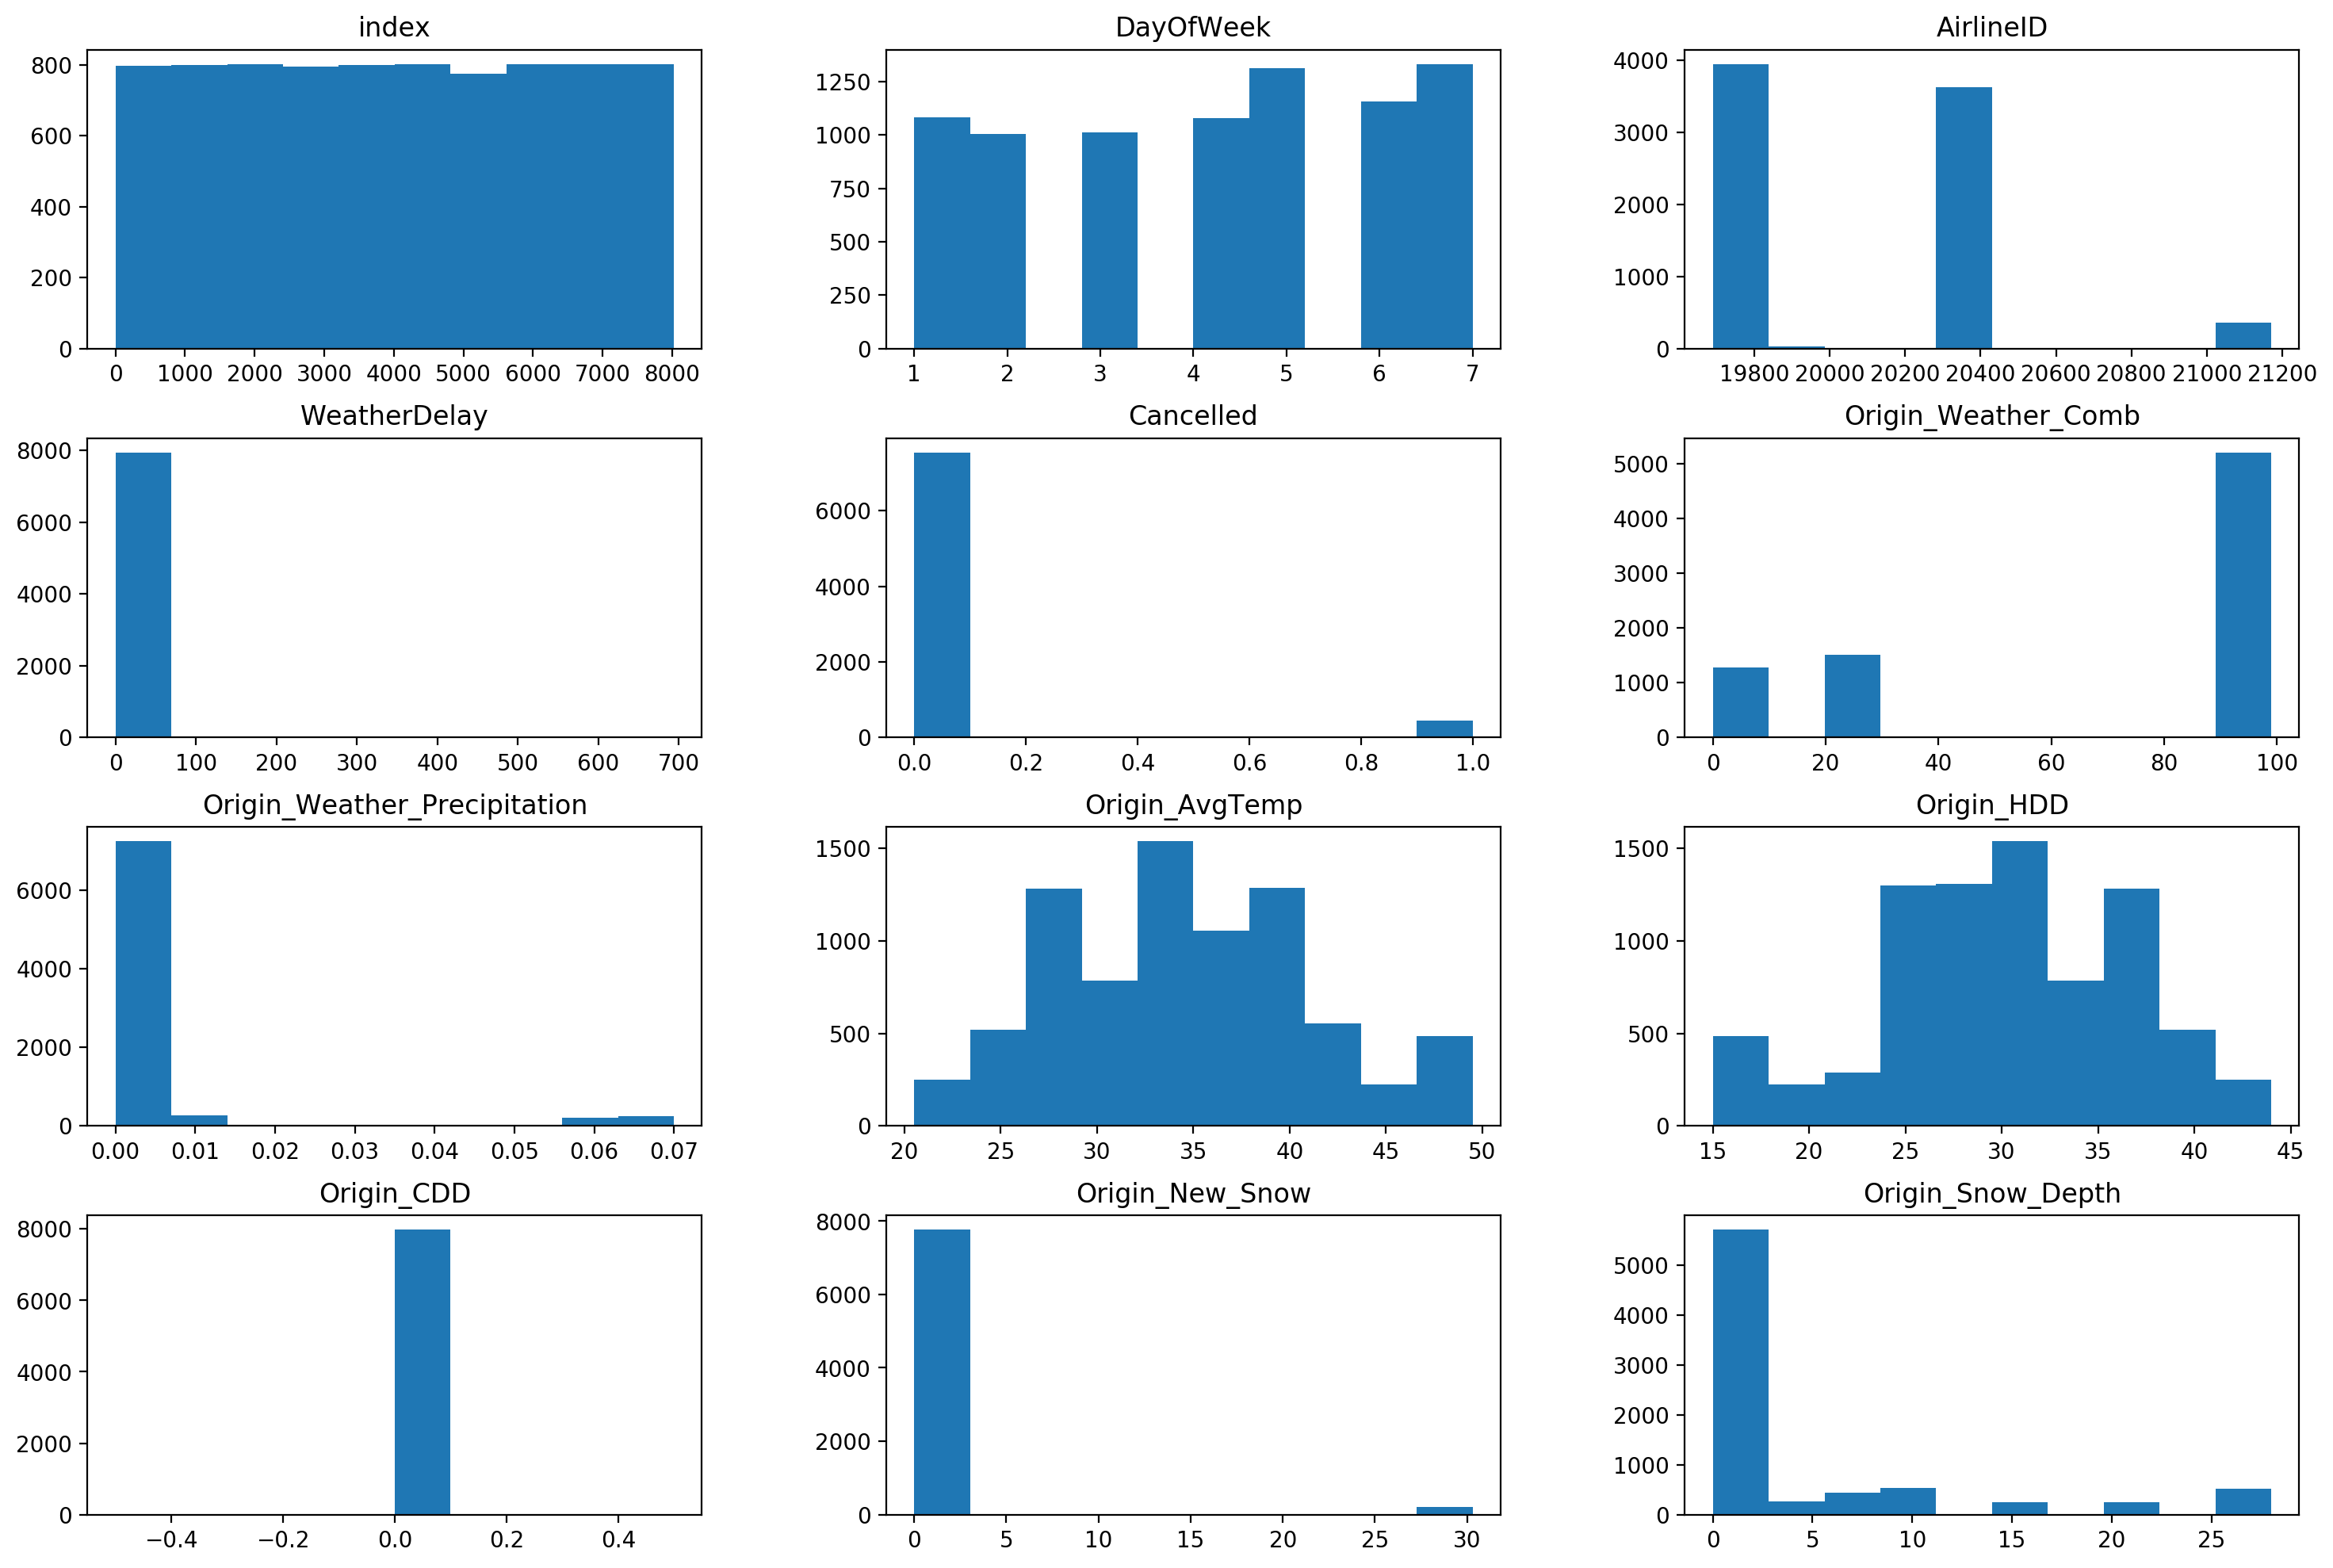

In [42]:
# Histogram of parameters in our data:

# histograms
JFK_Flights_FS_autopilot_df.hist(grid=False, figsize=(18,12))
plt.show()



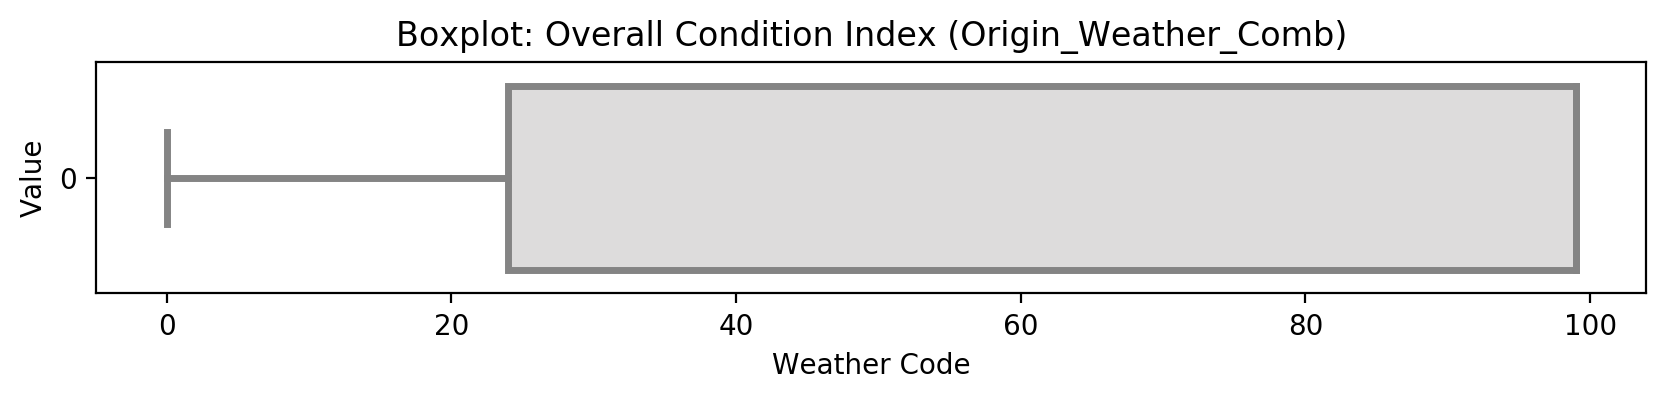

In [25]:
# Boxplot of age as one way of showing distribution
fig = plt.figure(figsize = (10,1.5))
plt.title ('Boxplot: Overall Condition Index (Origin_Weather_Comb)')
plt.xlabel('Weather Code')
plt.ylabel('Value')
sns.boxplot(data=JFK_Flights_FS_autopilot_df['Origin_Weather_Comb'], 
            palette="coolwarm", orient='h', 
            linewidth=2.5)
plt.show()

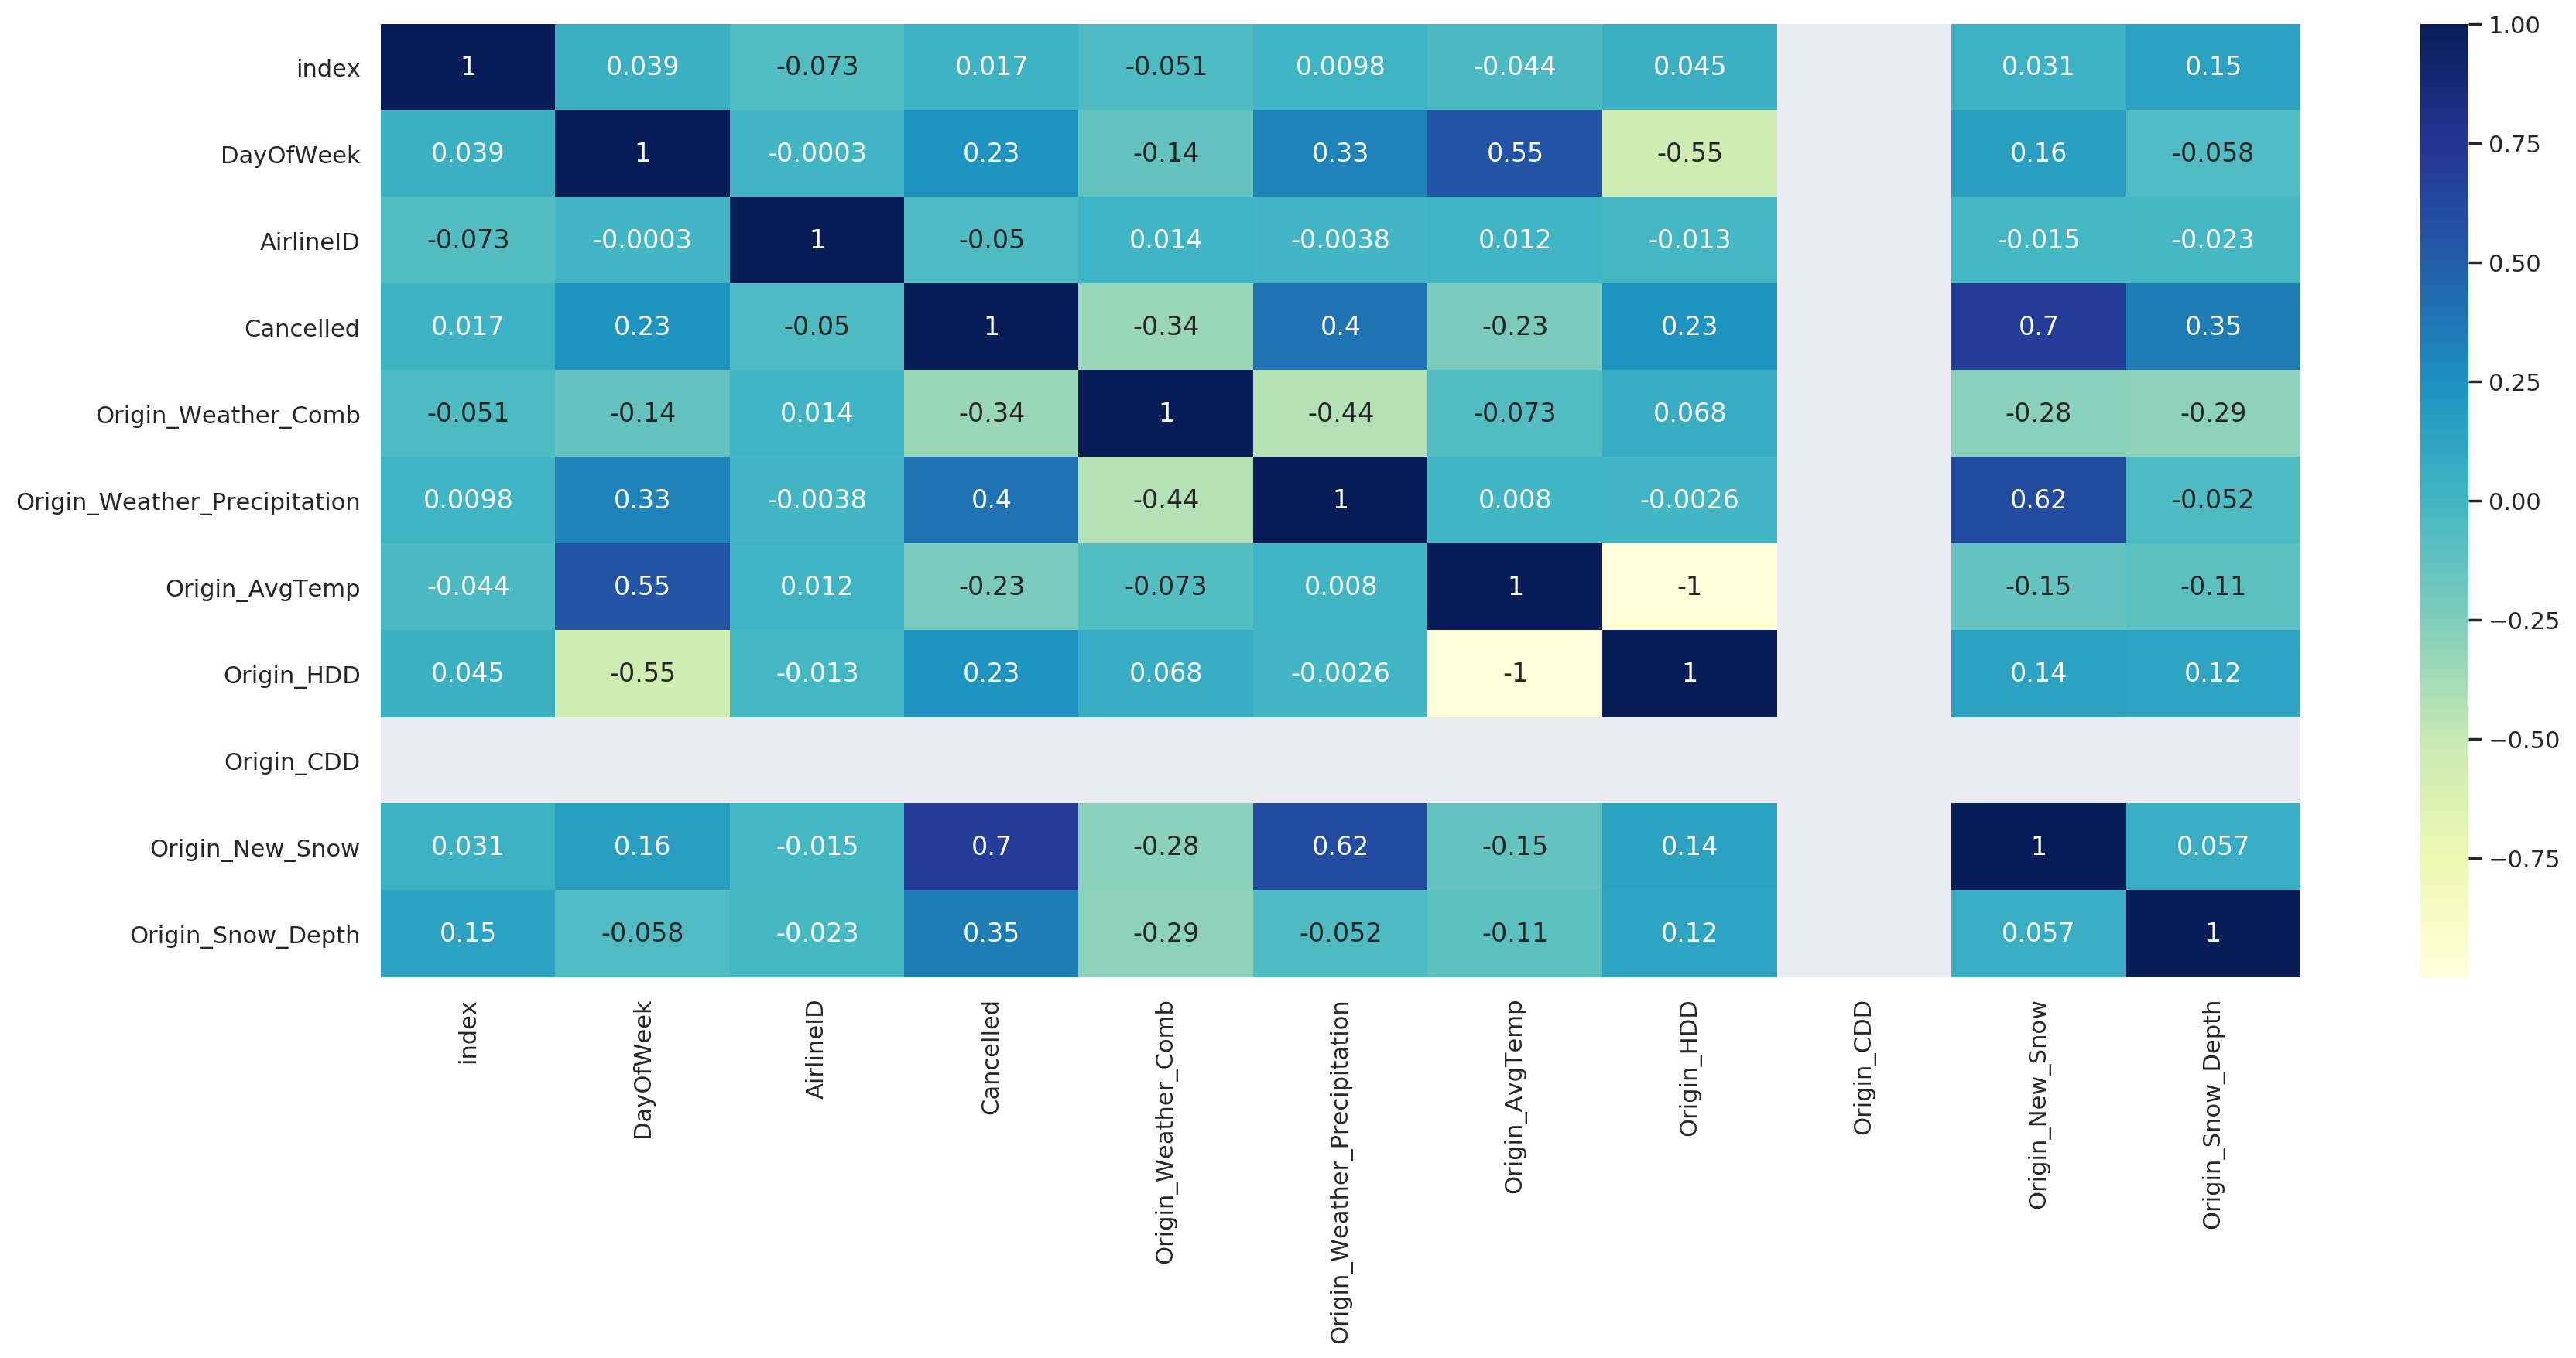

In [48]:
# USING ENTIRE DATASET
# plot the heatmap and annotation on it
#Correlation matrix 

corr_matrix_JFK = JFK_Flights_FS_autopilot_df.corr()
sns.set(rc = {'figure.figsize':(20,8)})
sns.heatmap(corr_matrix_JFK, cmap="YlGnBu", annot=True)
plt.show()

## Split Data for Model Training/Eval:

In [49]:
# USING ENTIRE DATASET X and Y SPLITS

categorical_features_JFK = ['AirlineID','DayOfWeek','Origin_Weather_Comb']
numerical_features_JFK = ['Origin_Weather_Precipitation','Origin_AvgTemp',
                             'Origin_HDD','Origin_CDD','Origin_New_Snow','Origin_Snow_Depth'
                             ]

# Generate dataframes with the different features

Xcat_JFK_df = JFK_Flights_FS_autopilot_df[categorical_features_JFK]

Xnum_JFK_df = JFK_Flights_FS_autopilot_df[numerical_features_JFK]

# Combine the two in order to maintain indices, used merge function
# although it should be automatic even with the join command, as
# both come from the same dataframe with no modifications.

# Create X and y for splitting and further pre-processing:

X_JFK_df = pd.merge(Xcat_JFK_df, Xnum_JFK_df, left_index=True, 
                       right_index=True)

y_JFK_df = JFK_Flights_FS_autopilot_df[['Cancelled']]

In [50]:
X_train_JFK, X_vt_JFK, y_train_JFK, y_vt_JFK = train_test_split(
    X_JFK_df,y_JFK_df, stratify = y_JFK_df['Cancelled'],test_size = 0.1,
                                                              random_state = 508)

In [51]:
X_val_JFK, X_test_JFK, y_val_JFK, y_test_JFK = train_test_split(
    X_vt_JFK,y_vt_JFK, stratify = y_vt_JFK['Cancelled'],test_size = 0.5,
                                                              random_state = 508)

## Scaling and Encoding for BYOS Logistic Regression:

In [56]:
# Pre-Process Training data categorical variables and 
# scale/normalize numericals by column

X_train_JFK_num = X_train_JFK[numerical_features_JFK]
X_test_JFK_num =  X_test_JFK[numerical_features_JFK]

sc = StandardScaler()
sc_fitted = sc.fit(X_train_JFK_num)

X_train_JFK_sc = pd.DataFrame(sc_fitted.transform(X_train_JFK_num), 
                               columns=X_train_JFK_num.columns)
X_test_JFK_sc = pd.DataFrame(sc_fitted.transform(X_test_JFK_num), 
                              columns=X_test_JFK_num.columns)

In [59]:
# Hot encode categorical features:


X_train_JFK_cat = X_train_JFK[categorical_features_JFK]
X_test_JFK_cat =  X_test_JFK[categorical_features_JFK]


enc_hot = OneHotEncoder(categories = 'auto', sparse=False)

cat_feat = enc_hot.fit(X_train_JFK_cat)



X_train_JFK_enc = pd.DataFrame(cat_feat.transform(X_train_JFK_cat), 
                               columns=cat_feat.get_feature_names(
                                   categorical_features_JFK))

X_test_JFK_enc = pd.DataFrame(cat_feat.transform(X_test_JFK_cat), 
                               columns=cat_feat.get_feature_names(
                                   categorical_features_JFK))



In [61]:
# Combine the two dataframes for scaled and encoded 
# numerical and categorical features:

X_train_JFK_pre = pd.merge(X_train_JFK_sc, X_train_JFK_enc, left_index=True, 
                       right_index=True)

X_test_JFK_pre = pd.merge(X_test_JFK_sc, X_test_JFK_enc, left_index=True, 
                       right_index=True)

In [62]:
# change y_train shape
y_train_JFK = np.ravel(y_train_JFK)
y_test_JFK = np.ravel(y_test_JFK)

In [43]:
#df_train, df_holdout = train_test_split(JFK_Flights_FS_autopilot_df, test_size=0.10, stratify=JFK_Flights_FS_autopilot_df['Cancelled'])

In [44]:
#df_validation, df_test = train_test_split(df_holdout, test_size=0.50, stratify=df_holdout['Cancelled'])

In [45]:
#X_train=df_train.drop('Cancelled', axis=1)
#y_train = df_train['Cancelled']
#X_validation = df_validation.drop('Cancelled', axis=1)
#y_validation = df_validation["Cancelled"]
#X_test = df_test.drop('Cancelled', axis=1)
#y_test = df_test["Cancelled"]

## Logistic regression (bring your own script)

In [63]:
# Un-Tuned Logistic Regression Model
logit_reg = LogisticRegression(random_state=508) 
logit_reg.fit(X_train_JFK_pre, y_train_JFK)

# Predict on validation set
logit_reg_pred1 = logit_reg.predict(X_test_JFK_pre)

# accuracy and classification report (Untuned Model)
print('Untuned Logistic Regression Model')
print('Accuracy Score')
print(accuracy_score(y_test_JFK, logit_reg_pred1))
print('Classification Report \n', 
       classification_report(y_test_JFK, logit_reg_pred1))

Untuned Logistic Regression Model
Accuracy Score
0.9874686716791979
Classification Report 
               precision    recall  f1-score   support

           0       1.00      0.99      0.99       377
           1       0.84      0.95      0.89        22

    accuracy                           0.99       399
   macro avg       0.92      0.97      0.94       399
weighted avg       0.99      0.99      0.99       399



## XGBoost model implementation:

## Generate tables in Athena:

### Create Database:

In [8]:
database_name = 'flight_analysis'
table_name = 'cancellation_codes_4'

In [9]:
statement = "CREATE DATABASE IF NOT EXISTS {}".format(database_name)
print(statement)
pd.read_sql(statement, conn)

CREATE DATABASE IF NOT EXISTS flight_analysis


""


In [10]:
cancellation_s3 = 's3://sagemaker-us-east-1-993410942383/content-project/airline_data/cancellation_table'

### Create Cancellation Codes Table:

In [11]:
statement = """CREATE EXTERNAL TABLE IF NOT EXISTS {}.{}(
         Index string,
         Code string,
         Description string
) ROW FORMAT DELIMITED FIELDS TERMINATED BY '\,' LINES TERMINATED BY '\\n' LOCATION '{}'
TBLPROPERTIES ('skip.header.line.count'='1')""".format(
    database_name, table_name, cancellation_s3
)

In [12]:
pd.read_sql(statement, conn)

""


Verify the table was created by way of a Query:

In [13]:
query = "SELECT * FROM {}.{}".format(database_name, table_name)
pd.read_sql(query, conn)

,index,code,description
0,0,A,Carrier
1,1,B,Weather
2,2,C,National Air System
3,3,D,Security


In [15]:
airlineID_s3 = 's3://sagemaker-us-east-1-993410942383/content-project/airline_data/airlineID_carrier_table'
flights_s3 = 's3://sagemaker-us-east-1-993410942383/content-project/airline_data/airline_flights_table'
weather_s3 = 's3://sagemaker-us-east-1-993410942383/content-project/airline_data/WeatherUS_2016'
customer_s3 = 's3://sagemaker-us-east-1-993410942383/content-project/airline_data/Airline_Customer_Service'
airportCodes_s3 = 's3://sagemaker-us-east-1-993410942383/content-project/airline_data/airport_codes_table'

In [191]:
table_name_airportCodes = 'airport_codes_table'
table_name_airlineID = 'airlineID_table'
table_name_customer = 'customer_service_table2'
table_name_flights = 'flights_table_21'
table_weather = 'weather_table'

### Ariline Carrier ID table:

In [169]:
statement_carrier = """CREATE EXTERNAL TABLE IF NOT EXISTS {}.{}(
         Index string,
         Code string,
         Description string
) ROW FORMAT DELIMITED FIELDS TERMINATED BY '\,' LINES TERMINATED BY '\\n' LOCATION '{}'
TBLPROPERTIES ('skip.header.line.count'='1')""".format(
    database_name, table_name_airlineID, airlineID_s3
)

In [170]:
pd.read_sql(statement_carrier, conn)

""


In [171]:
query_carrier = "SELECT * FROM {}.{} ORDER BY Index asc LIMIT 10".format(database_name, table_name_airlineID)
pd.read_sql(query_carrier, conn)

,index,code,description
0,0,19031,Mackey International Inc.: MAC
1,1,19032,Munz Northern Airlines Inc.: XY
2,10,19041,Valdez Airlines: VEZ
3,100,19131,Birchwood Air Service: BIR
4,1000,20032,Air Europe S.P.A.: PE
5,1001,20033,UFS Inc.: U2
6,1002,20034,Pacific International Airlines: PIQ
7,1003,20035,Air Florida Express: AFE
8,1004,20036,American Flight Group: AFG
9,1005,20037,Aviation Sales: AVL


### Airport Codes Table:

In [172]:
statement_airportcode = """CREATE EXTERNAL TABLE IF NOT EXISTS {}.{}(
         Index string,
         Code string,
         Description string
) ROW FORMAT SERDE 'org.apache.hadoop.hive.serde2.OpenCSVSerde'
 LOCATION '{}'
TBLPROPERTIES ('skip.header.line.count'='1')""".format(
    database_name, table_name_airportCodes, airportCodes_s3
)

In [173]:
pd.read_sql(statement_airportcode, conn)

""


In [174]:
query_airportcode = "SELECT * FROM {}.{} ORDER BY Index asc LIMIT 10".format(database_name, table_name_airportCodes)
pd.read_sql(query_airportcode, conn)

,index,code,description
0,0,01A,"Afognak Lake, AK: Afognak Lake Airport"
1,1,03A,"Granite Mountain, AK: Bear Creek Mining Strip"
2,10,1N7,"Blairstown, NJ: Blairstown Airport"
3,100,A93,"Bradley Lake Project, AK: Bradley Lake Project..."
4,1000,CGF,"Cleveland, OH: Cuyahoga County"
5,1001,CGH,"Sao Paulo, Brazil: Congonhas"
6,1002,CGI,"Cape Girardeau, MO: Cape Girardeau Regional"
7,1003,CGK,"Jakarta, Indonesia: Soekarno-Hatta International"
8,1004,CGM,"Camiguin, Philippines: Camiguin Airport"
9,1005,CGN,"Cologne, Germany: Koln Bonn"


### Generate Tables from Dataframes:

In [49]:
# save new dataframes in S3 bucket as csv:
dff_Origin_JFK.to_csv('s3://sagemaker-us-east-1-993410942383/content-project/airline_data/Flights_JFK/Flights_JFK_clean.csv')
dff_Weather_JFK.to_csv('s3://sagemaker-us-east-1-993410942383/content-project/airline_data/Weather_JFK/Weather_JFK_clean.csv')

In [50]:
JFK_weather_data.to_csv('s3://sagemaker-us-east-1-993410942383/content-project/airline_data/JFK_weather_detailed/Weather_JFK__detailed_clean.csv')

In [170]:
dff_Origin_JFK_mod.to_csv('s3://sagemaker-us-east-1-993410942383/content-project/airline_data/Flights_JFK_mod/dff_Origin_JFK_mod.csv')

In [171]:
JFK_flight_path = 's3://sagemaker-us-east-1-993410942383/content-project/airline_data/Flights_JFK'
JFK_flight_path_mod = 's3://sagemaker-us-east-1-993410942383/content-project/airline_data/Flights_JFK_mod'
JFK_weather_path = 's3://sagemaker-us-east-1-993410942383/content-project/airline_data/Weather_JFK'
JFK_weather_detailed_path = 's3://sagemaker-us-east-1-993410942383/content-project/airline_data/JFK_weather_detailed'

In [52]:
database_name = 'flight_analysis'


In [182]:
table_JFK_flights = 'Flights_JFK31'
table_JFK_weather2016 = 'Weather2016_JFK6'
table_JFK_weather_detailed = 'Weather_detailed_JFK6'
table_JFK_flights_mod = 'Flights_JFK_mod'

In [97]:
statement_flights_JFK = """CREATE EXTERNAL TABLE {}.{}(
         count int,
         Index int,
         Year	int,
         Quarter int,
         month int,
         DayofMonth 	int,         
         DayOfWeek 	int,
         FlightDate 	string,
         UniqueCarrier 	string,
         AirlineID	string,
         Carrier	string,
         TailNum	string,
         FlightNum	string,
         OriginAirportID	string,
         OriginAirportSeqID	string,
         OriginCityMarketID	string,
         Origin	string,
         OriginCityName	string,
         OriginState	string,
         OriginStateFips	string,
         OriginStateName	string,
         OriginWac	string,
         DestAirportID	string,
         DestAirportSeqID	string,
         DestCityMarketID	string,
         Dest	string,
         DestCityName	string,
         DestState	string,
         DestStateFips	string,
         DestStateName	string,
         DestWac	string,
         CRSDepTime	string,
         DepTime	string,
         DepDelay	string,
         DepDelayMinutes	string,
         DepDel15	string,
         DepartureDelayGroups	string,
         DepTimeBlk	string,
         TaxiOut	string,
         WheelsOff	string,
         WheelsOn	string,
         TaxiIn	string,
         CRSArrTime	string,
         ArrTime	string,
         ArrDelay	string,
         ArrDelayMinutes	string,
         ArrDel15	string,
         ArrivalDelayGroups	string,
         ArrTimeBlk	string,
         Cancelled	int,
         CancellationCode	string,
         Diverted	string,
         CRSElapsedTime	string,
         ActualElapsedTime	string,
         AirTime	string,
         Flights	string,
         Distance	string,
         DistanceGroup	string,
         CarrierDelay	string,
         WeatherDelay	string,
         NASDelay	string,
         SecurityDelay	string,
         LateAircraftDelay	string,
         FirstDepTime	string,
         TotalAddGTime	string,
         LongestAddGTime	string,
         DivAirportLandings	string,
         DivReachedDest	string,
         DivActualElapsedTime	string,
         DivArrDelay	string,
         DivDistance	string,
         Div1Airport	string,
         Div1AirportID	string,
         Div1AirportSeqID	string,
         Div1WheelsOn	string,
         Div1TotalGTime	string,
         Div1LongestGTime	string,
         Div1WheelsOff	string,
         Div1TailNum	string,
         Div2Airport	string,
         Div2AirportID	string,
         Div2AirportSeqID	string,
         Div2WheelsOn	string,
         Div2TotalGTime	string,
         Div2LongestGTime	string
) ROW FORMAT SERDE 'org.apache.hadoop.hive.serde2.OpenCSVSerde'
 LOCATION '{}'
TBLPROPERTIES ('skip.header.line.count'='1')""".format(
    database_name, table_JFK_flights, JFK_flight_path
)

In [98]:
pd.read_sql(statement_flights_JFK, conn)

""


In [209]:
queryflightsJFK = "SELECT cancellationcode FROM {}.{} LIMIT 10".format(database_name, table_JFK_flights)
pd.read_sql(queryflightsJFK, conn)

,cancellationcode
0,
1,
2,
3,
4,
5,
6,
7,
8,
9,


In [173]:
statement_flights_JFK_mod = """CREATE EXTERNAL TABLE {}.{}(
         count int,
         Index int,
         Year	int,
         Quarter int,
         month int,
         DayofMonth 	int,         
         DayOfWeek 	int,
         FlightDate 	string,
         UniqueCarrier 	string,
         AirlineID	string,
         Carrier	string,
         TailNum	string,
         FlightNum	string,
         OriginAirportID	string,
         OriginAirportSeqID	string,
         OriginCityMarketID	string,
         Origin	string,
         OriginCityName	string,
         OriginState	string,
         OriginStateFips	string,
         OriginStateName	string,
         OriginWac	string,
         DestAirportID	string,
         DestAirportSeqID	string,
         DestCityMarketID	string,
         Dest	string,
         DestCityName	string,
         DestState	string,
         DestStateFips	string,
         DestStateName	string,
         DestWac	string,
         CRSDepTime	string,
         DepTime	string,
         DepDelay	string,
         DepDelayMinutes	string,
         DepDel15	string,
         DepartureDelayGroups	string,
         DepTimeBlk	string,
         TaxiOut	string,
         WheelsOff	string,
         WheelsOn	string,
         TaxiIn	string,
         CRSArrTime	string,
         ArrTime	string,
         ArrDelay	string,
         ArrDelayMinutes	string,
         ArrDel15	string,
         ArrivalDelayGroups	string,
         ArrTimeBlk	string,
         Cancelled	int,
         CancellationCode	string,
         Diverted	string,
         CRSElapsedTime	string,
         ActualElapsedTime	string,
         AirTime	string,
         Flights	string,
         Distance	string,
         DistanceGroup	string,
         CarrierDelay	string,
         WeatherDelay	string,
         NASDelay	string,
         SecurityDelay	string,
         LateAircraftDelay	string,
         FirstDepTime	string,
         TotalAddGTime	string,
         LongestAddGTime	string,
         DivAirportLandings	string,
         DivReachedDest	string,
         DivActualElapsedTime	string,
         DivArrDelay	string,
         DivDistance	string,
         Div1Airport	string,
         Div1AirportID	string,
         Div1AirportSeqID	string,
         Div1WheelsOn	string,
         Div1TotalGTime	string,
         Div1LongestGTime	string,
         Div1WheelsOff	string,
         Div1TailNum	string,
         Div2Airport	string,
         Div2AirportID	string,
         Div2AirportSeqID	string,
         Div2WheelsOn	string,
         Div2TotalGTime	string,
         Div2LongestGTime	string
) ROW FORMAT SERDE 'org.apache.hadoop.hive.serde2.OpenCSVSerde'
 LOCATION '{}'
TBLPROPERTIES ('skip.header.line.count'='1')""".format(
    database_name, table_JFK_flights_mod, JFK_flight_path_mod
)

In [174]:
pd.read_sql(statement_flights_JFK_mod, conn)

""


In [175]:
queryflightsJFK_mod = "SELECT * FROM {}.{} LIMIT 10".format(database_name, table_JFK_flights_mod)
pd.read_sql(queryflightsJFK_mod, conn)

,count,index,year,quarter,month,dayofmonth,dayofweek,flightdate,uniquecarrier,airlineid,...,div1totalgtime,div1longestgtime,div1wheelsoff,div1tailnum,div2airport,div2airportid,div2airportseqid,div2wheelson,div2totalgtime,div2longestgtime
0,0,88,2016,1,1,1,5,2016-01-01,AA,19805,...,,,,,,,,,,
1,1,89,2016,1,1,2,6,2016-01-02,AA,19805,...,,,,,,,,,,
2,2,90,2016,1,1,3,7,2016-01-03,AA,19805,...,,,,,,,,,,
3,3,91,2016,1,1,4,1,2016-01-04,AA,19805,...,,,,,,,,,,
4,4,92,2016,1,1,5,2,2016-01-05,AA,19805,...,,,,,,,,,,
5,5,93,2016,1,1,6,3,2016-01-06,AA,19805,...,,,,,,,,,,
6,6,94,2016,1,1,7,4,2016-01-07,AA,19805,...,,,,,,,,,,
7,7,95,2016,1,1,8,5,2016-01-08,AA,19805,...,,,,,,,,,,
8,8,96,2016,1,1,9,6,2016-01-09,AA,19805,...,,,,,,,,,,
9,9,97,2016,1,1,10,7,2016-01-10,AA,19805,...,,,,,,,,,,


In [55]:
statement_weather2016_JFK = """CREATE EXTERNAL TABLE IF NOT EXISTS {}.{}(
         count int,
         Index int,
         Type string,
         Severity string,
         StartTime string,
         EndTime string,
         Precipitation string,
         TimeZone string,
         AirportCode string,
         LocationLat string,
         LocationLng string,
         City string,
         County string,
         State string,
         ZipCode string,
         Weather_Comb_Var int
        
)
ROW FORMAT DELIMITED FIELDS TERMINATED BY '\,' LINES TERMINATED BY '\\n' LOCATION '{}'
TBLPROPERTIES ('skip.header.line.count'='1')""".format(
    database_name, table_JFK_weather2016, JFK_weather_path
)

In [56]:
pd.read_sql(statement_weather2016_JFK, conn)

""


In [57]:
queryweather2016 = "SELECT * FROM {}.{} ORDER BY Index asc LIMIT 10".format(database_name, table_JFK_weather2016)
pd.read_sql(queryweather2016, conn)

,count,index,type,severity,starttime,endtime,precipitation,timezone,airportcode,locationlat,locationlng,city,county,state,zipcode,weather_comb_var
0,0,52242,Rain,Light,2016-01-10 03:51:00,2016-01-10 06:51:00,0.01,US/Eastern,JFK,40.6392,-73.7639,Jamaica,Queens,NY,11430.0,24
1,1,52243,Rain,Light,2016-01-10 08:51:00,2016-01-10 09:51:00,0.05,US/Eastern,JFK,40.6392,-73.7639,Jamaica,Queens,NY,11430.0,24
2,2,52244,Rain,Moderate,2016-01-10 09:51:00,2016-01-10 10:51:00,0.25,US/Eastern,JFK,40.6392,-73.7639,Jamaica,Queens,NY,11430.0,26
3,3,52245,Rain,Heavy,2016-01-10 10:51:00,2016-01-10 11:33:00,0.31,US/Eastern,JFK,40.6392,-73.7639,Jamaica,Queens,NY,11430.0,27
4,4,52246,Rain,Moderate,2016-01-10 11:33:00,2016-01-10 14:51:00,0.84,US/Eastern,JFK,40.6392,-73.7639,Jamaica,Queens,NY,11430.0,26
5,5,52247,Fog,Severe,2016-01-10 16:51:00,2016-01-10 21:26:00,0.0,US/Eastern,JFK,40.6392,-73.7639,Jamaica,Queens,NY,11430.0,7
6,6,52248,Rain,Light,2016-01-10 21:26:00,2016-01-10 22:11:00,0.05,US/Eastern,JFK,40.6392,-73.7639,Jamaica,Queens,NY,11430.0,24
7,7,52249,Rain,Light,2016-01-10 22:51:00,2016-01-10 23:51:00,0.01,US/Eastern,JFK,40.6392,-73.7639,Jamaica,Queens,NY,11430.0,24
8,8,52250,Rain,Light,2016-01-12 21:51:00,2016-01-12 22:51:00,0.0,US/Eastern,JFK,40.6392,-73.7639,Jamaica,Queens,NY,11430.0,24
9,9,52251,Snow,Light,2016-01-14 10:51:00,2016-01-14 11:51:00,0.0,US/Eastern,JFK,40.6392,-73.7639,Jamaica,Queens,NY,11430.0,0


In [183]:
statement_weatherdet_JFK = """CREATE EXTERNAL TABLE IF NOT EXISTS {}.{}(
         Index int,
         Date string,
         MaxTemp float,
         MinTemp int,
         AvgTemp int,
         DepTemp float,
         HDD int,
         CDD int,
         Precipitation float,
         First_Snow float,
         Snow_Depth float
        
)
ROW FORMAT DELIMITED FIELDS TERMINATED BY '\,' LINES TERMINATED BY '\\n' LOCATION '{}'
TBLPROPERTIES ('skip.header.line.count'='1')""".format(
    database_name, table_JFK_weather_detailed, JFK_weather_detailed_path
)

In [184]:
pd.read_sql(statement_weatherdet_JFK, conn)

""


In [185]:
queryweatherdet = "SELECT * FROM {}.{} LIMIT 10".format(database_name, table_JFK_weather_detailed)
pd.read_sql(queryweatherdet, conn)

,index,date,maxtemp,mintemp,avgtemp,deptemp,hdd,cdd,precipitation,first_snow,snow_depth
0,0,2016-01-01,44.0,36,40,5.4,25,0,0.00,0.0,0.0
1,1,2016-01-02,41.0,34,37,3.1,27,0,0.00,0.0,0.0
2,2,2016-01-03,48.0,35,41,7.3,23,0,0.00,0.0,0.0
3,3,2016-01-04,38.0,15,26,-7.5,38,0,0.00,0.0,0.0
4,4,2016-01-05,29.0,12,20,-13.4,44,0,0.00,0.0,0.0
5,5,2016-01-06,40.0,21,30,-3.2,34,0,0.00,0.0,0.0
6,6,2016-01-07,46.0,27,36,3.0,28,0,0.00,0.0,0.0
7,7,2016-01-08,47.0,32,39,6.1,25,0,0.00,0.0,0.0
8,8,2016-01-09,53.0,40,46,13.3,18,0,0.02,0.0,0.0
9,9,2016-01-10,58.0,41,49,16.4,15,0,1.28,0.0,0.0


In [140]:
print(s3_staging_dir)

s3://sagemaker-us-east-1-993410942383/athena/staging


In [196]:
test="""CREATE TABLE IF NOT EXISTS flight_analysis.test5
   AS
SELECT
  ftest.flightdate, dtest.hdd
FROM
  "flight_analysis"."flights_jfk_mod" as ftest
  JOIN "flight_analysis"."weather_detailed_jfk6" as dtest
ON
  ftest.flightdate = dtest.date"""
  

In [197]:
pd.read_sql(test, conn)

,rows


In [200]:
query_test = "SELECT * FROM {}.test5 LIMIT 10".format(database_name)
pd.read_sql(query_test, conn)

,flightdate,hdd
0,2016-01-01,25
1,2016-01-02,27
2,2016-01-03,23
3,2016-01-04,38
4,2016-01-05,44
5,2016-01-06,34
6,2016-01-07,28
7,2016-01-08,25
8,2016-01-09,18
9,2016-01-10,15


In [210]:
statement_first_join = """CREATE TABLE IF NOT EXISTS flight_analysis.Flights_JFK_temp35
            AS 
            SELECT 
            f.index, 
            f.flightdate,  
            f.airlineid, 
            f.origin,  
            f.cancelled, 
            f.cancellationcode, 
            d.maxtemp,
            d.mintemp,
            d.avgtemp,
            d.deptemp,
            d.hdd,
            d.cdd, 
            d.first_snow, 
            d.snow_depth 
            FROM "flight_analysis"."Flights_JFK_mod" as f 
            JOIN "flight_analysis"."Weather_detailed_JFK6" as d 
            ON f.flightdate = d.date 
            """

#LOCATION '{}'
#.format(s3_staging_dir)

#AS 
#(SELECT
#GROUP BY f.index

In [211]:
pd.read_sql(statement_first_join, conn)

,rows


In [212]:
query_firstJoin = "SELECT * FROM {}.Flights_JFK_temp35 LIMIT 10".format(database_name)
pd.read_sql(query_firstJoin, conn)

,index,flightdate,airlineid,origin,cancelled,cancellationcode,maxtemp,mintemp,avgtemp,deptemp,hdd,cdd,first_snow,snow_depth
0,88,2016-01-01,19805,JFK,0,,44.0,36,40,5.4,25,0,0.0,0.0
1,89,2016-01-02,19805,JFK,0,,41.0,34,37,3.1,27,0,0.0,0.0
2,90,2016-01-03,19805,JFK,0,,48.0,35,41,7.3,23,0,0.0,0.0
3,91,2016-01-04,19805,JFK,0,,38.0,15,26,-7.5,38,0,0.0,0.0
4,92,2016-01-05,19805,JFK,0,,29.0,12,20,-13.4,44,0,0.0,0.0
5,93,2016-01-06,19805,JFK,0,,40.0,21,30,-3.2,34,0,0.0,0.0
6,94,2016-01-07,19805,JFK,0,,46.0,27,36,3.0,28,0,0.0,0.0
7,95,2016-01-08,19805,JFK,0,,47.0,32,39,6.1,25,0,0.0,0.0
8,96,2016-01-09,19805,JFK,0,,53.0,40,46,13.3,18,0,0.0,0.0
9,97,2016-01-10,19805,JFK,0,,58.0,41,49,16.4,15,0,0.0,0.0


In [ ]:
pd.read_sql("""CREATE TABLE Flights_JFK  AS 
            SELECT a.Index, 
            a.FlightDate,  
            a.Airlineid, 
            a.Origin, 
            m.Location_lat, 
            m.Location_long, 
            a.Cancelled as Canceled, 
            a.Cancellation_code, 
            m.weather_comb_var, 
            m.type, 
            m.severity 
            FROM Flights_JFK31 as a 
            JOIN Weather2016_JFK6 as m 
            ON a.Origin = m.airportcode 
            WHERE DATE(a.FlightDate) 
            BETWEEN DATE(m.starttime) AND DATE(m.endtime) GROUP BY a.index_flights""", conn)


## EDA Questions: 

### How do the various airlines compare when it came to Reasons for Canceled Flights?

[Text(0, 0, 'Carrier'),
 Text(0, 0, 'Weather'),
 Text(0, 0, 'National Air System')]

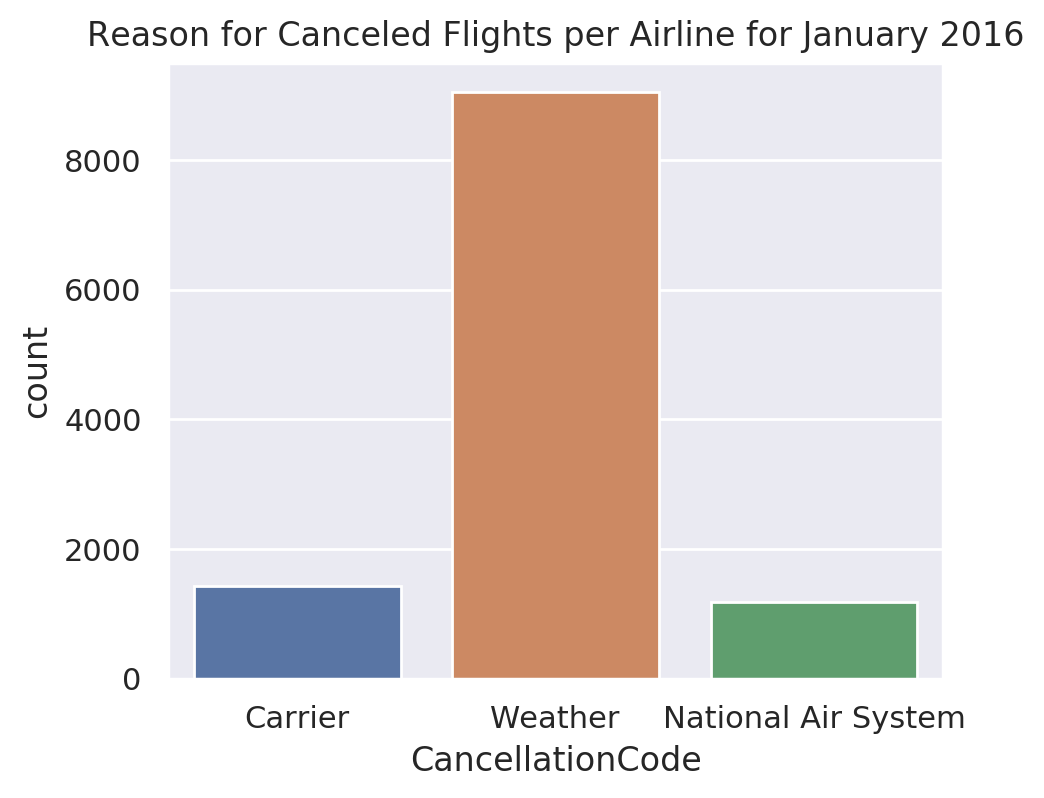

In [71]:
sns.set(rc={'figure.figsize':(5,4)})

g=sns.countplot(data=flights_df,
              x='CancellationCode'
             )
g.set_title('Reason for Canceled Flights per Airline for January 2016')
g.set_xticklabels(['Carrier','Weather','National Air System'])

[Text(0, 0, 'Carrier'),
 Text(0, 0, 'Weather'),
 Text(0, 0, 'National Air System')]

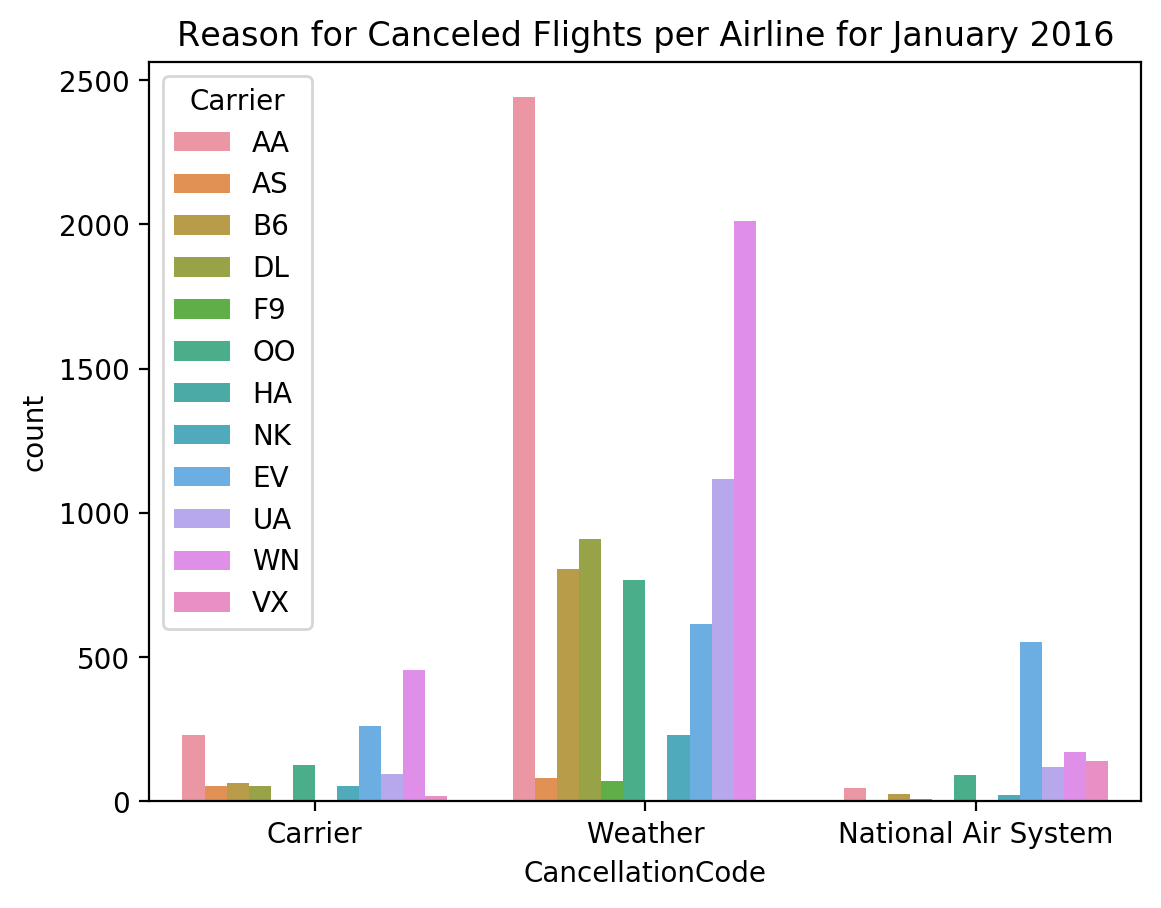

In [382]:

g=sns.countplot(data=flights_df,
              x='CancellationCode',
              hue='Carrier'
             )
g.set_title('Reason for Canceled Flights per Airline for January 2016')
g.set_xticklabels(['Carrier','Weather','National Air System'])

Hawaiian Airlines and Frontier Airlines have the least cancellations for the month of January 2016 as they don't even show up for these cancellation reasons.

### How many flights per day were scheduled versus canceled?

In [383]:
#for index, row in flights_df.iterrows():
# Sum of canceled daily flights:
dff = flights_df.groupby(["FlightDate"]).Cancelled.sum().reset_index()
#dff.head()

# Sum of total number of flights (since Quarter is always 1):
dff2 = flights_df.groupby(["FlightDate"]).Quarter.count().reset_index()
dff2.rename(columns={'Quarter':'Total_no_Flights'}, inplace=True)
#dff2.head()

dff_flights=pd.merge(dff, dff2, on = "FlightDate")
dff_flights.head()
#flights_sum=flights_df['FlightDate'].groupby(flights_df['Cancelled'] == 1)

,FlightDate,Cancelled,Total_no_Flights
0,2016-01-01,57,13019
1,2016-01-02,52,14869
2,2016-01-03,97,15878
3,2016-01-04,87,15570
4,2016-01-05,204,14582


In [203]:
flights_sum.head()

0      2016-01-06
1      2016-01-07
2      2016-01-08
3      2016-01-09
4      2016-01-10
72     2016-01-16
79     2016-01-23
80     2016-01-24
81     2016-01-25
102    2016-01-15
Name: FlightDate, dtype: object

[Text(0, 0, '01/01'),
 Text(0, 0, '01/02'),
 Text(0, 0, '01/03'),
 Text(0, 0, '01/04'),
 Text(0, 0, '01/05'),
 Text(0, 0, '01/06'),
 Text(0, 0, '01/07'),
 Text(0, 0, '01/08'),
 Text(0, 0, '01/09'),
 Text(0, 0, '01/10'),
 Text(0, 0, '01/11'),
 Text(0, 0, '01/12'),
 Text(0, 0, '01/13'),
 Text(0, 0, '01/14'),
 Text(0, 0, '01/15'),
 Text(0, 0, '01/16'),
 Text(0, 0, '01/17'),
 Text(0, 0, '01/18'),
 Text(0, 0, '01/19'),
 Text(0, 0, '01/20'),
 Text(0, 0, '01/21'),
 Text(0, 0, '01/22'),
 Text(0, 0, '01/23'),
 Text(0, 0, '01/24'),
 Text(0, 0, '01/25'),
 Text(0, 0, '01/26'),
 Text(0, 0, '01/27'),
 Text(0, 0, '01/28'),
 Text(0, 0, '01/29'),
 Text(0, 0, '01/30'),
 Text(0, 0, '01/31')]

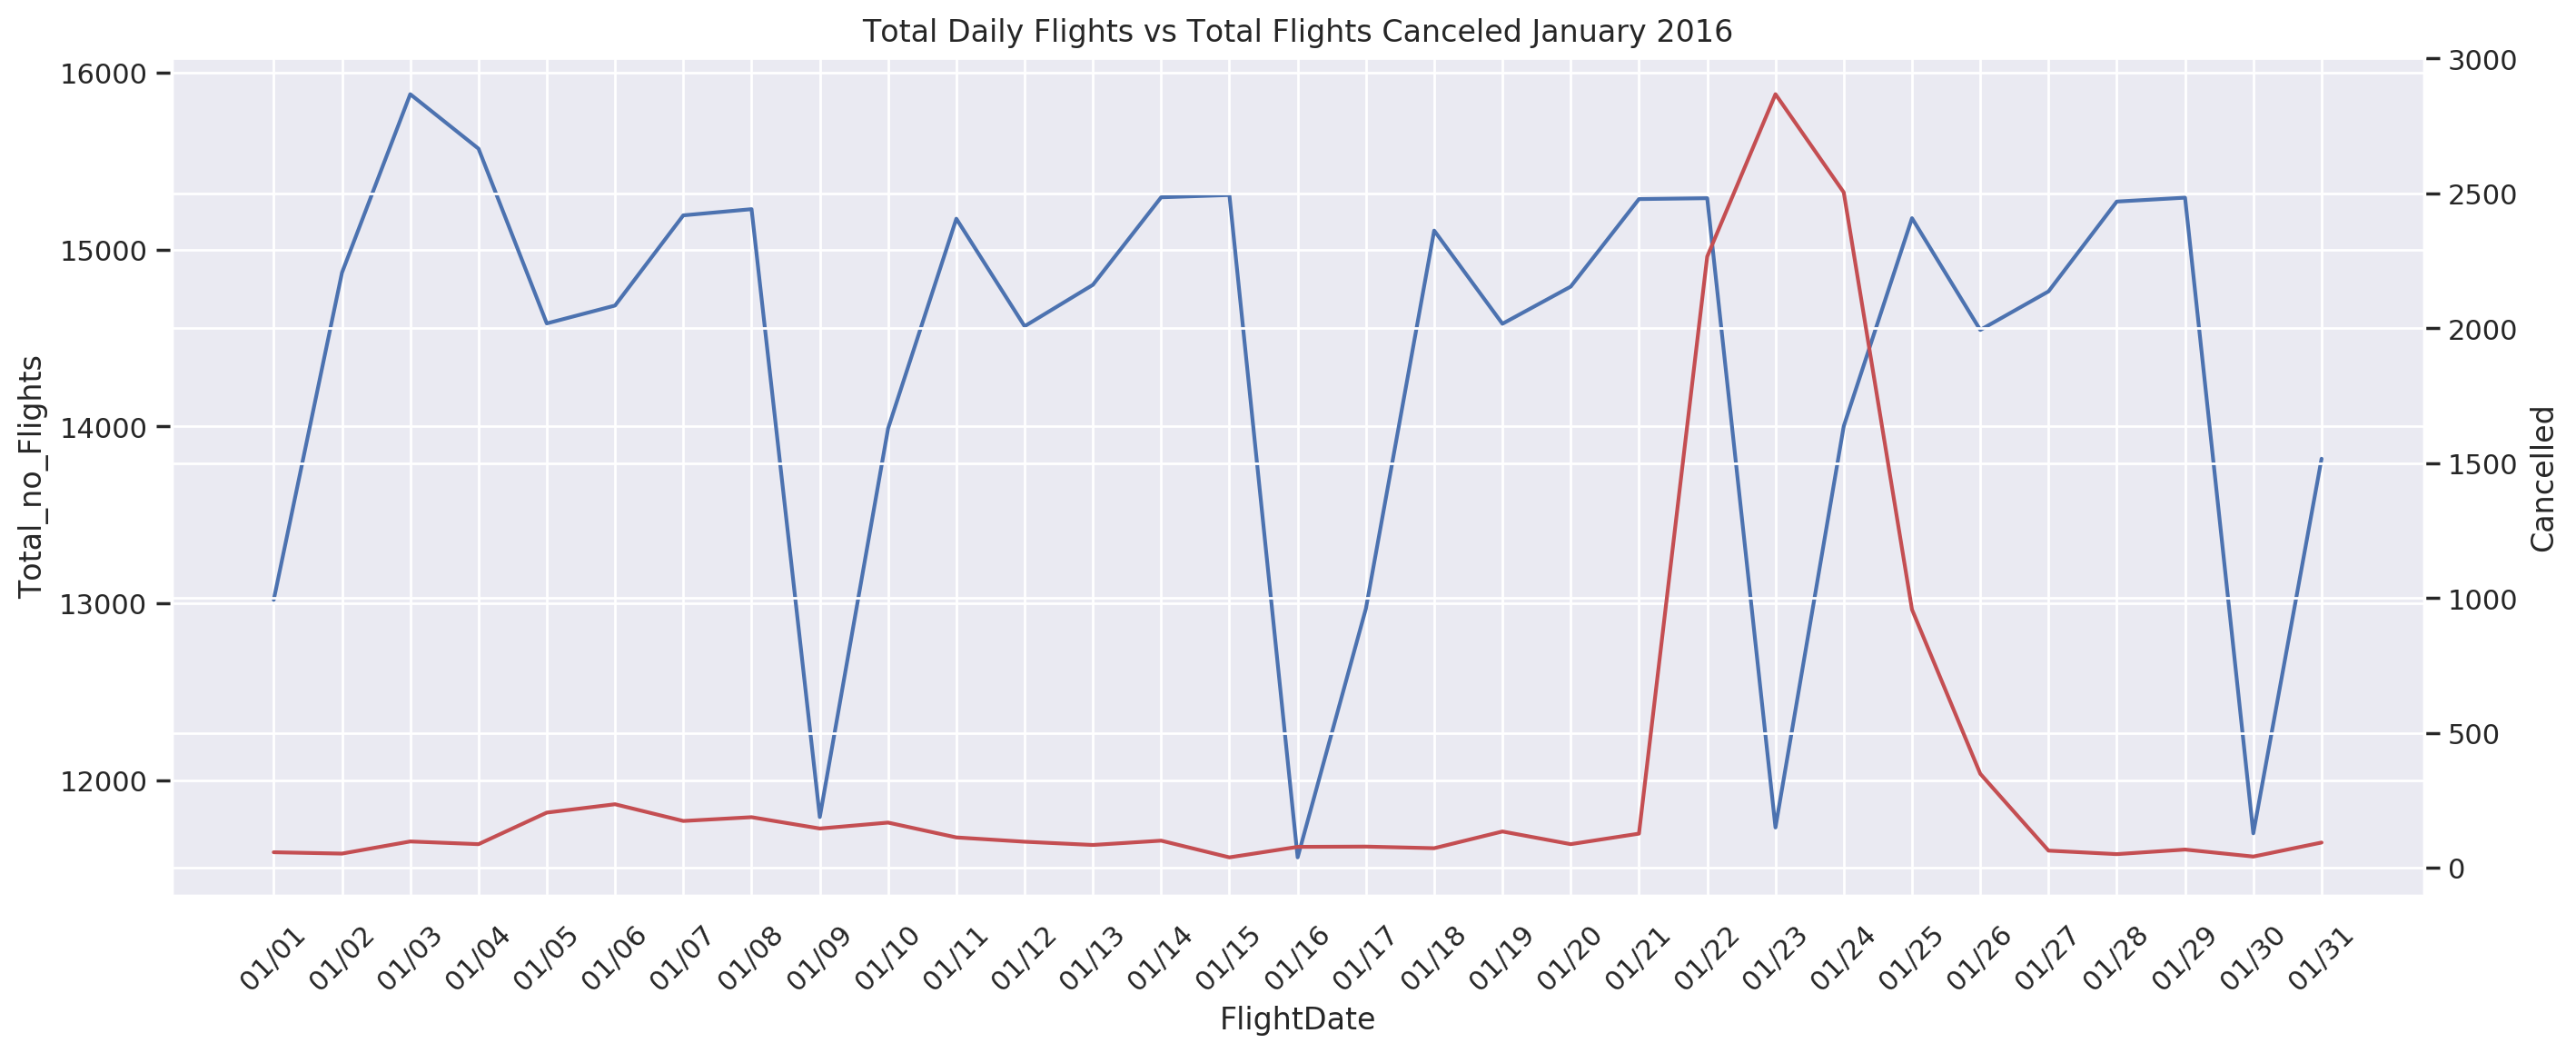

In [384]:
sns.set(rc={'figure.figsize':(10,7)})

fig, ax1 = plt.subplots(figsize=(16, 6))
ax1.set_title("Total Daily Flights vs Total Flights Canceled January 2016")
ax2 = ax1.twinx()
#ax3 = ax1.twinx()

#ax2.set(ylim=(0, y2_limit))
g1 = sns.lineplot(data = dff_flights, x = "FlightDate", y = "Total_no_Flights", ax = ax1, color = 'b') # plots the first set
g2 = sns.lineplot(data = dff_flights, x = "FlightDate", y = "Cancelled", ax = ax2, color = 'r') # plots the second set 
#g3 = sns.lineplot(data = df, x = x1, y = y3, ax = ax3, color = y3_color)

#g_line = sns.lineplot(x="FlightDate", y="Total_no_Flights", data=dff_flights)
#g_line.add_lineplot(x="FlightDate",y="Cancelled",data=dff_flights)
g1.set_xticklabels(labels=["01/01","01/02","01/03","01/04","01/05",
                          "01/06","01/07","01/08","01/09","01/10","01/11",
                          "01/12","01/13","01/14","01/15","01/16","01/17",
                          "01/18","01/19","01/20","01/21","01/22","01/23",
                          "01/24","01/25","01/26","01/27","01/28","01/29",
                          "01/30","01/31"], rotation=45)
#g1.set_title("Total Daily Flights vs Total Flights Canceled January 2016")
##g.set_xticklabels(['2011','2012','2013','2014','2015','2016','2017','2018'])

Might be interesting to find out what happened between 01/20 and 01/27 of 2016 that caused the larger increase in canceled flights within the domestic US.

Keep in mind the double axis to keep both plots on top of one another, but the number of canceled flights is significantly smaller than the number of total flights scheduled for each day.

### Which airports had the most cancellations?

In [385]:
#for index, row in flights_df.iterrows():
# Sum of canceled daily flights:
dff_Origin_airportcode = flights_df.groupby(["Origin"]).Cancelled.sum().reset_index()
#dff.head()
dff_Dest_airportcode = flights_df.groupby(["Origin"]).Cancelled.sum().reset_index()


In [386]:
dff_Origin_airportcode.head()

,Origin,Cancelled
0,ABE,8
1,ABQ,12
2,ABR,0
3,ABY,0
4,ACT,0


In [387]:
dff_airportOrigin = dff_Origin_airportcode.sort_values(['Cancelled'], ascending=False)
dff_airportDest = dff_Dest_airportcode.sort_values(['Cancelled'], ascending=False)


Text(0.5, 1.0, 'Cancellations per domestic US airports for January 2016')

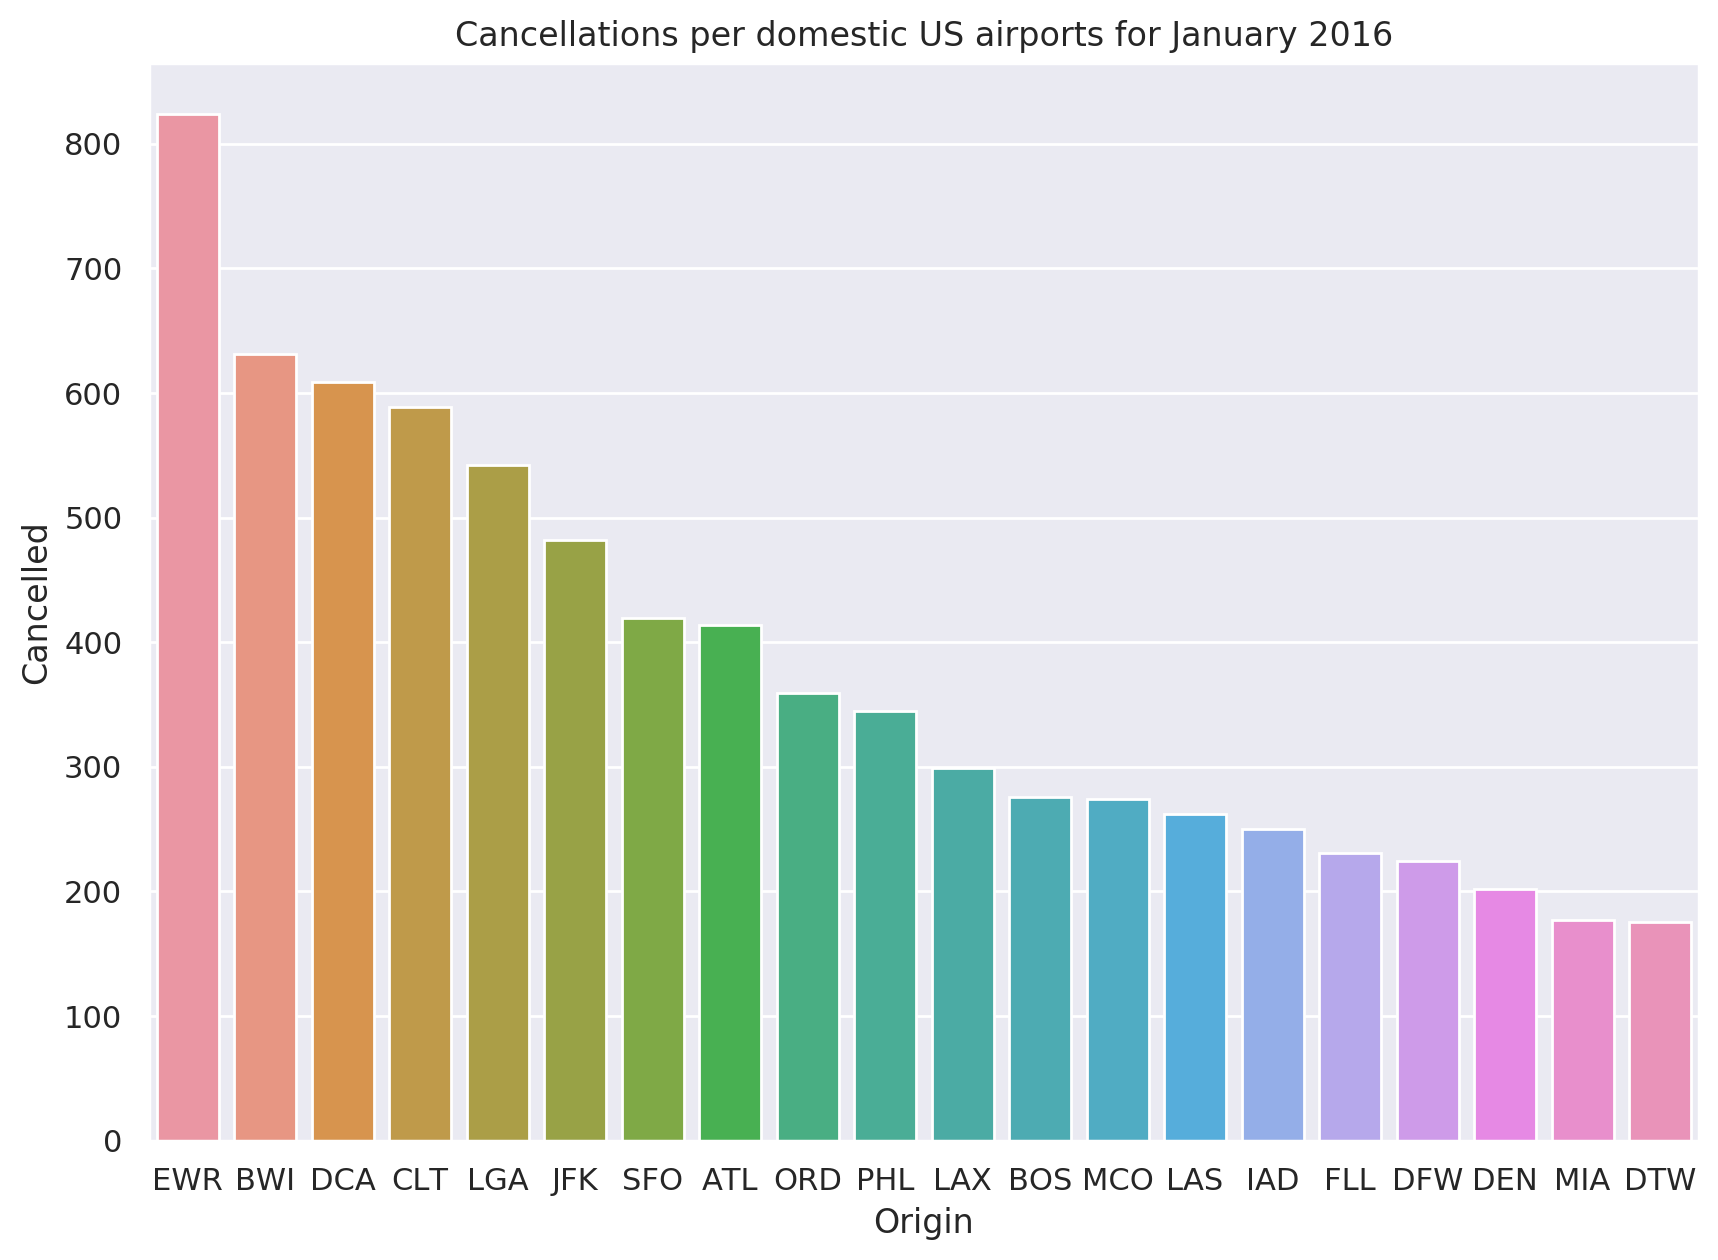

In [388]:
g_bar=sns.barplot(x="Origin", y="Cancelled", data=dff_airportOrigin.iloc[0:20])
g_bar.set_title("Cancellations per domestic US airports for January 2016")


### How do Canceled Flights look like for JFK?

In [281]:
flights_df.head()

,Unnamed: 0,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,UniqueCarrier,AirlineID,Carrier,...,Div1TotalGTime,Div1LongestGTime,Div1WheelsOff,Div1TailNum,Div2Airport,Div2AirportID,Div2AirportSeqID,Div2WheelsOn,Div2TotalGTime,Div2LongestGTime
0,0,2016,1,1,6,3,2016-01-06,AA,19805,AA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2016,1,1,7,4,2016-01-07,AA,19805,AA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2016,1,1,8,5,2016-01-08,AA,19805,AA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,2016,1,1,9,6,2016-01-09,AA,19805,AA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,2016,1,1,10,7,2016-01-10,AA,19805,AA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [389]:
# Percentage of canceled flights from total flights:
x=dff_Origin_JFK.shape
xx=dff_Origin_JFK['Cancelled'].sum()
xx/x[0]

0.06004734022673477

In [277]:
dff_Origin_JFK.tail()

,index,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,UniqueCarrier,AirlineID,Carrier,...,Div1TotalGTime,Div1LongestGTime,Div1WheelsOff,Div1TailNum,Div2Airport,Div2AirportID,Div2AirportSeqID,Div2WheelsOn,Div2TotalGTime,Div2LongestGTime
8022,423989,2016,1,1,13,3,2016-01-13 07:00:00,DL,19790,DL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8023,423992,2016,1,1,13,3,2016-01-13 19:30:00,DL,19790,DL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8024,423994,2016,1,1,13,3,2016-01-13 17:00:00,DL,19790,DL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8025,423995,2016,1,1,13,3,2016-01-13 16:15:00,DL,19790,DL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8026,423996,2016,1,1,13,3,2016-01-13 20:00:00,DL,19790,DL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


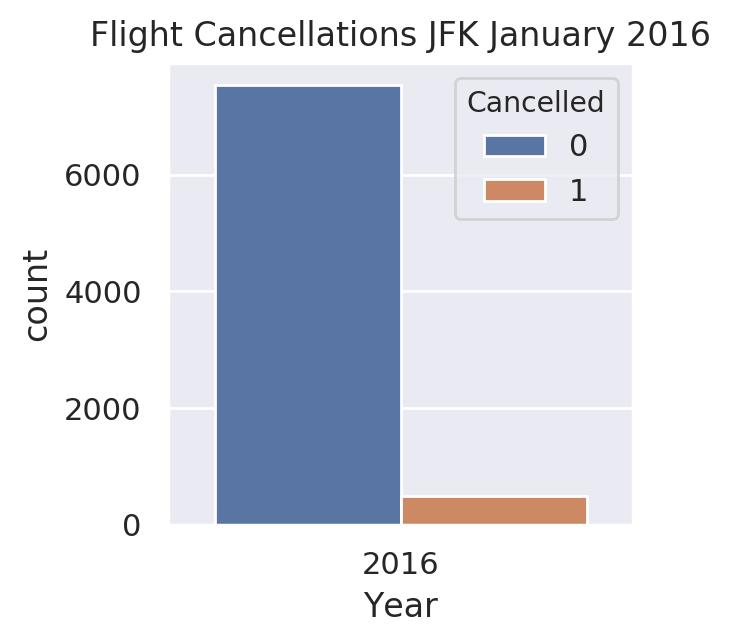

In [390]:
sns.set(rc={'figure.figsize':(3,3)})

sns.countplot(data=dff_Origin_JFK, x="Year", hue="Cancelled").set_title("Flight Cancellations JFK January 2016")
plt.show()

6% of flights in January were canceled at JFK

### What is the most common weather type and severity in the weather dataset for January 2016 US Airports?

In [392]:
#weather_df= pd.read_csv("s3://sagemaker-us-east-1-993410942383/content-project/airline_data/WeatherUS_2016/WeatherUS_2016.csv")
#weather_df.head()

In [9]:
#weather_df.rename(columns={'StartTime(UTC)':'StartTime'}, inplace=True)
#weather_df.rename(columns={'EndTime(UTC)':'EndTime'}, inplace=True)


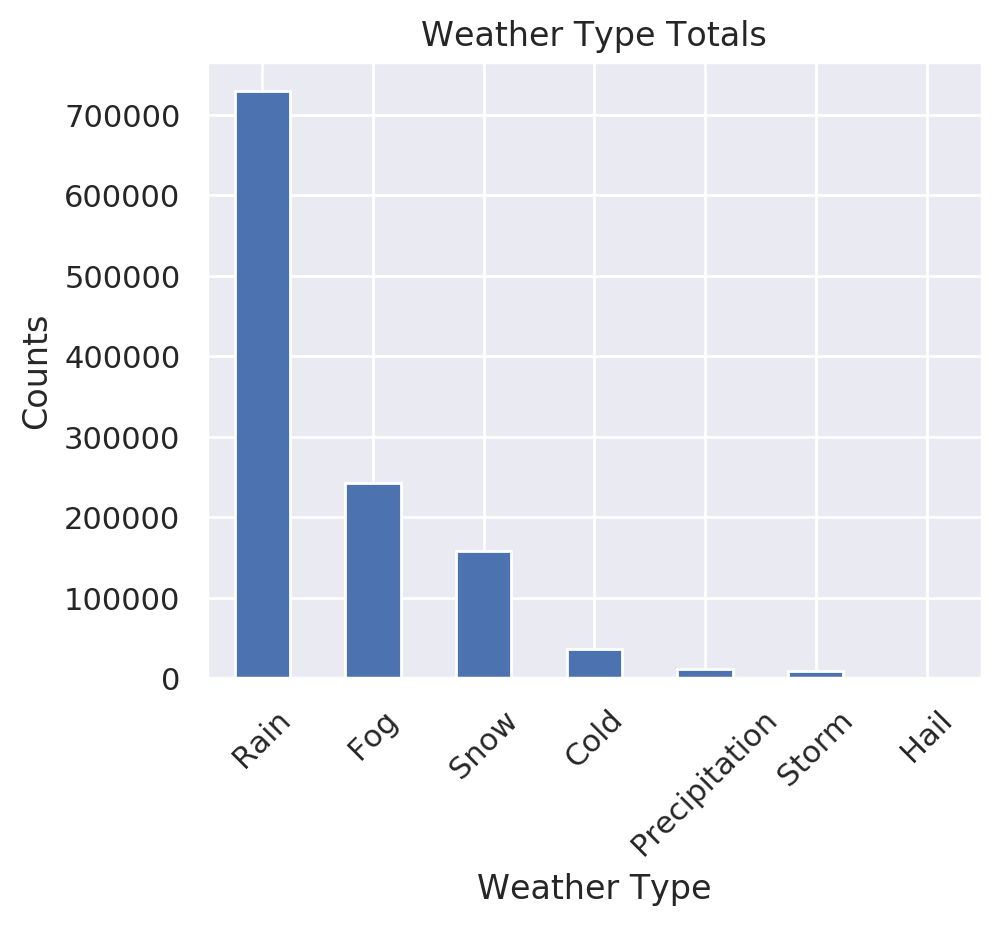

In [391]:
sns.set(rc={'figure.figsize':(5,4)})

weather_df['Type'].value_counts().plot(kind='bar')
plt.title('Weather Type Totals')
plt.xlabel('Weather Type')
plt.xticks(rotation=45)
plt.ylabel('Counts')
plt.show()

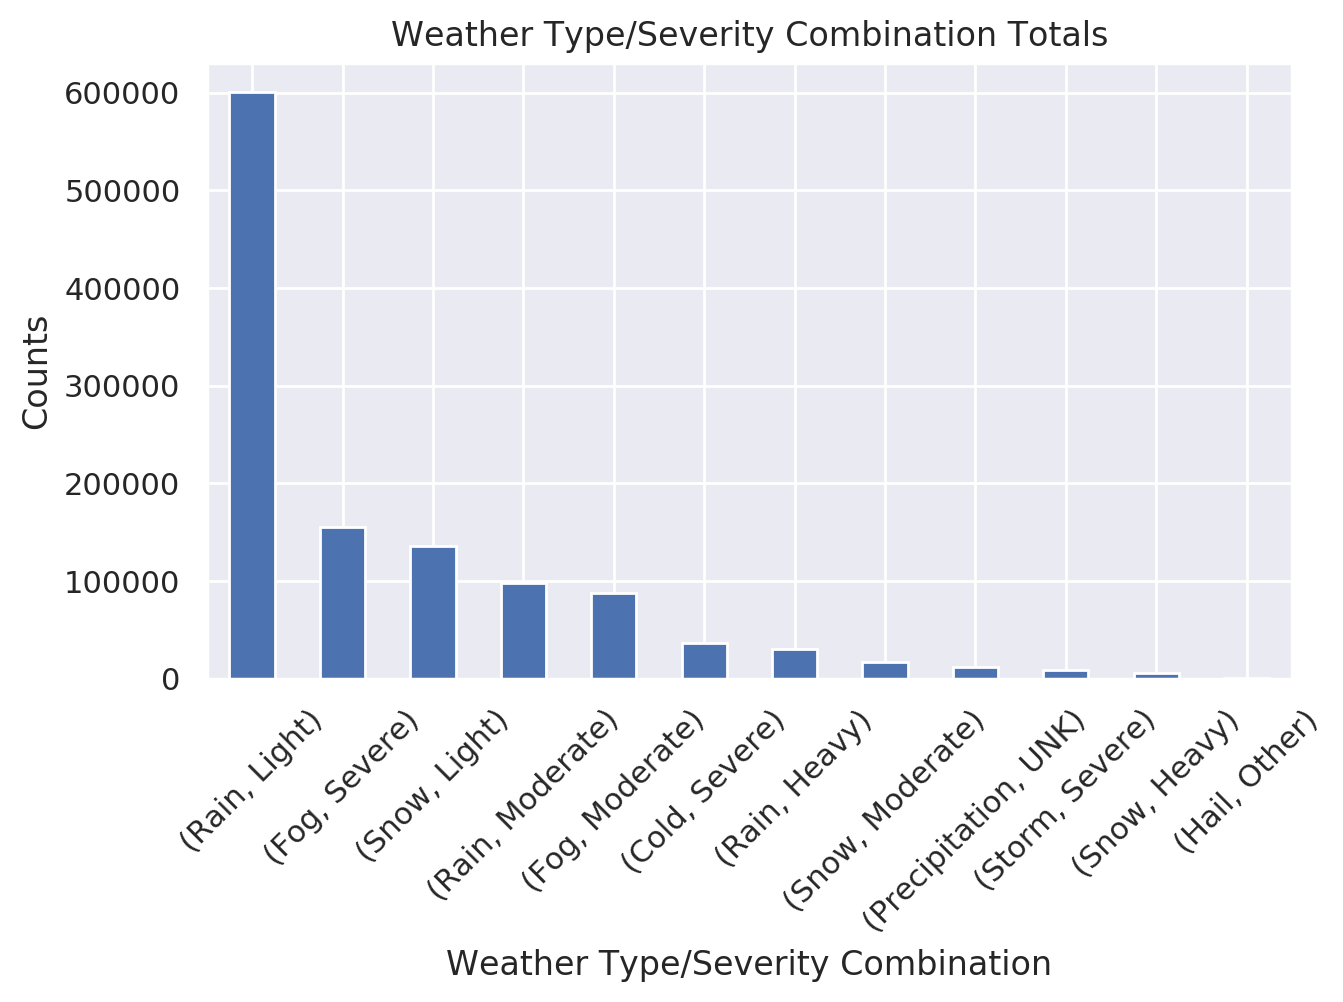

In [393]:
plt.subplots(figsize=(7, 4))

weather_df[['Type', 'Severity']].value_counts().plot(kind='bar')
plt.title('Weather Type/Severity Combination Totals')
plt.xlabel('Weather Type/Severity Combination')
plt.xticks(rotation=45)
plt.ylabel('Counts')
plt.show()

### What are the weather type/severity distributions for JFK in particular?

In [394]:
weather_JFK = weather_df[weather_df["AirportCode"]=="JFK"].reset_index()


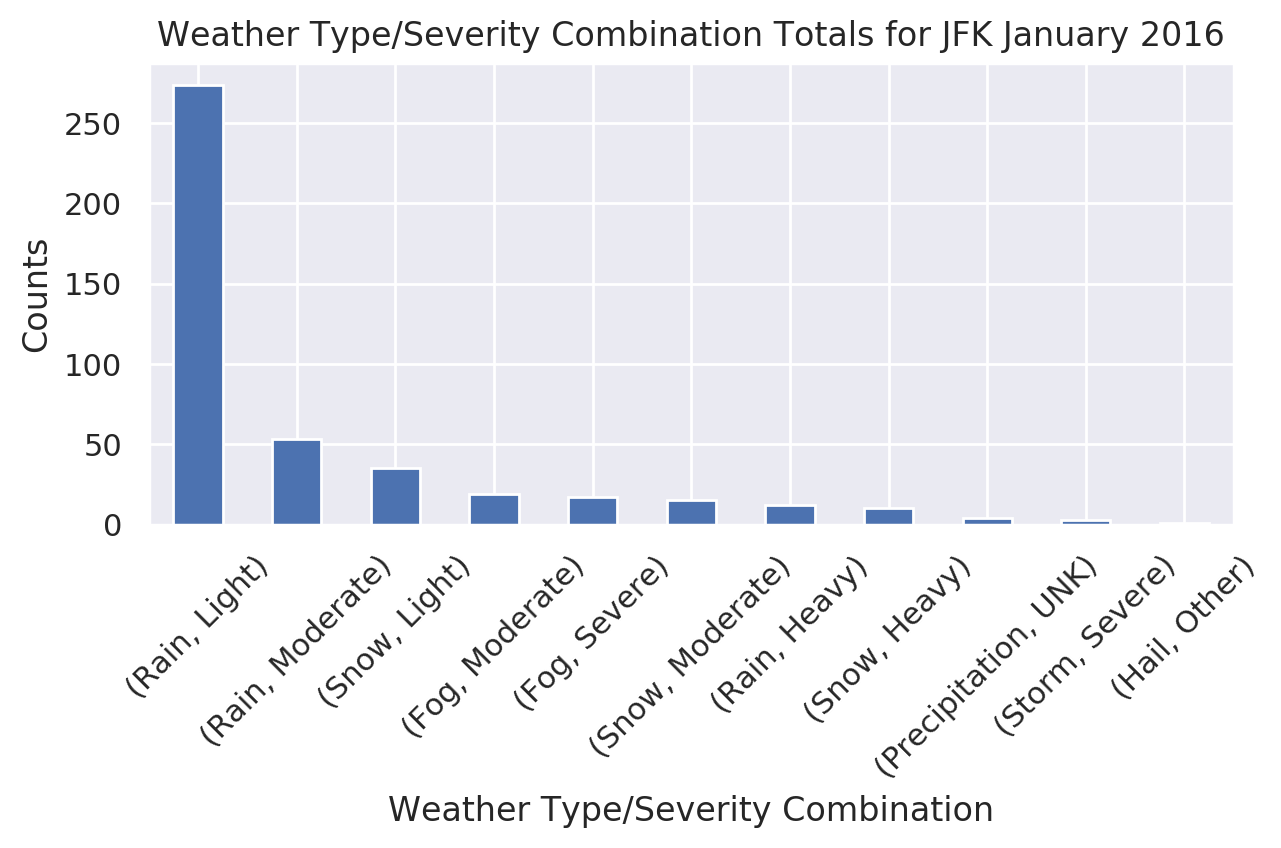

In [395]:
plt.subplots(figsize=(7, 3))

weather_JFK[['Type', 'Severity']].value_counts().plot(kind='bar')
plt.title('Weather Type/Severity Combination Totals for JFK January 2016')
plt.xlabel('Weather Type/Severity Combination')
plt.xticks(rotation=45)
plt.ylabel('Counts')
plt.show()

### What is the timeline of JFK weather conditions?

In [396]:
JFK_weather_data.head(20)

,Date,MaxTemp,MinTemp,AvgTemp,DepTemp,HDD,CDD,Precipitation,New_Snow,Snow_Depth
0,2016-01-01,44.0,36.0,40,5.4,25,0,0,0,0
1,2016-01-02,41.0,34.0,37.5,3.1,27,0,0,0,0
2,2016-01-03,48.0,35.0,41.5,7.3,23,0,0,0,0
3,2016-01-04,38.0,15.0,26.5,-7.5,38,0,0,0,0
4,2016-01-05,29.0,12.0,20.5,-13.4,44,0,0,0,0
5,2016-01-06,40.0,21.0,30.5,-3.2,34,0,0,0,0
6,2016-01-07,46.0,27.0,36.5,3,28,0,0,0,0
7,2016-01-08,47.0,32.0,39.5,6.1,25,0,0,0,0
8,2016-01-09,53.0,40.0,46.5,13.3,18,0,0.02,0,0
9,2016-01-10,58.0,41.0,49.5,16.4,15,0,1.28,0,0


In [397]:
JFK_weather_data.iloc[0:30].head()

,Date,MaxTemp,MinTemp,AvgTemp,DepTemp,HDD,CDD,Precipitation,New_Snow,Snow_Depth
0,2016-01-01,44.0,36.0,40,5.4,25,0,0,0,0
1,2016-01-02,41.0,34.0,37.5,3.1,27,0,0,0,0
2,2016-01-03,48.0,35.0,41.5,7.3,23,0,0,0,0
3,2016-01-04,38.0,15.0,26.5,-7.5,38,0,0,0,0
4,2016-01-05,29.0,12.0,20.5,-13.4,44,0,0,0,0


[Text(0, 0, '01/01'),
 Text(0, 0, '01/02'),
 Text(0, 0, '01/03'),
 Text(0, 0, '01/04'),
 Text(0, 0, '01/05'),
 Text(0, 0, '01/06'),
 Text(0, 0, '01/07'),
 Text(0, 0, '01/08'),
 Text(0, 0, '01/09')]

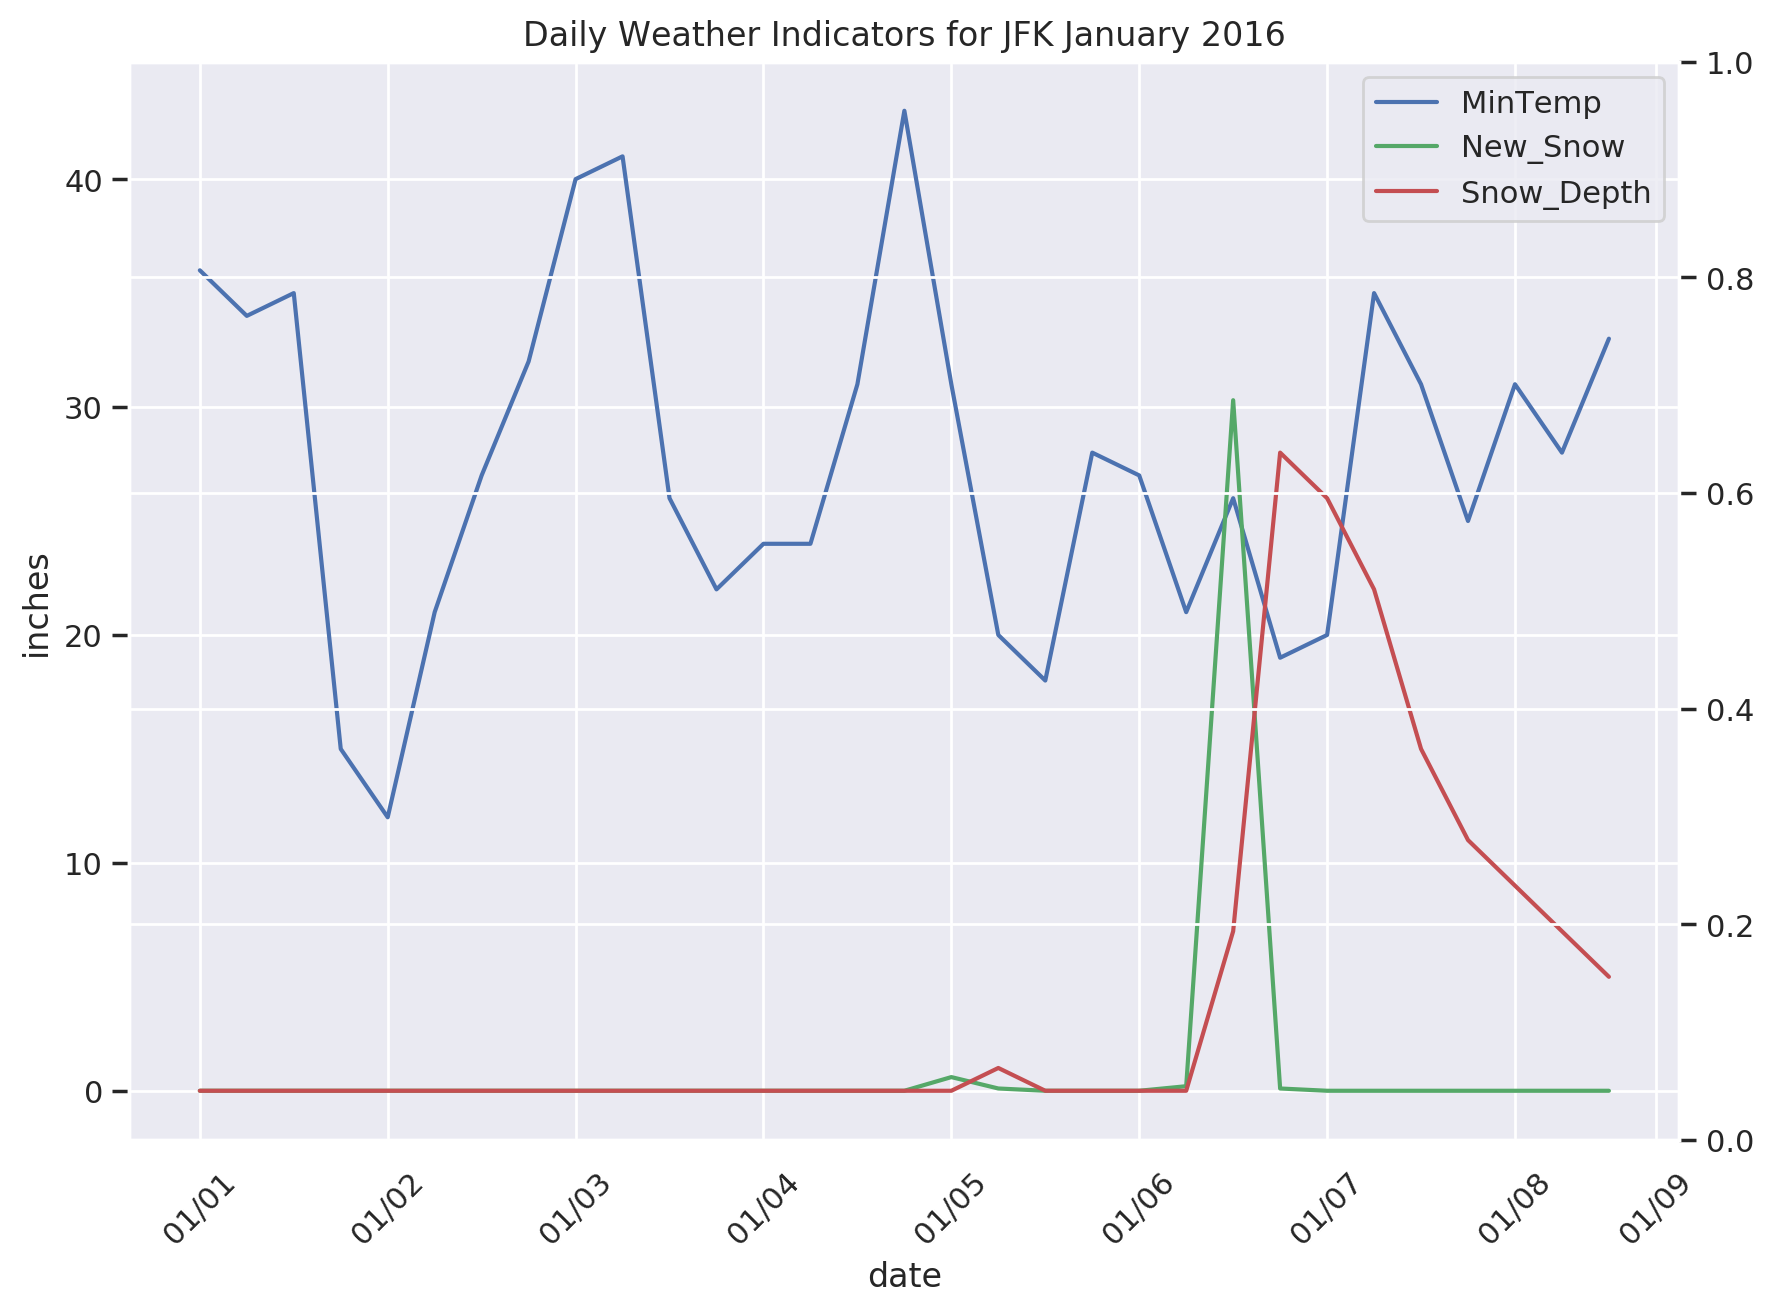

In [398]:
#sns.set(rc={'figure.figsize':(10,9)})

fig, ax1 = plt.subplots(figsize=(10, 7))
ax1.set_title("Daily Weather Indicators for JFK January 2016")
ax2 = ax1.twinx()
#ax3 = ax1.twinx()

#ax2.set(ylim=(0, y2_limit))
g1 = sns.lineplot(data = JFK_weather_data.iloc[0:31], x = "Date", y = "MinTemp", ax = ax1, color = 'b') # plots the first set
g1. legend (labels =["MinTemp"])

g1 = sns.lineplot(data = JFK_weather_data.iloc[0:31], x = "Date", y = "New_Snow", ax = ax1, color = 'g') # plots the second set 
g1 = sns.lineplot(data = JFK_weather_data.iloc[0:31], x = "Date", y = "Snow_Depth", ax = ax1, color = 'r') # plots the second set 

g1. legend (labels =["MinTemp","New_Snow","Snow_Depth"])
g1.set(xlabel ="date", ylabel = "inches")
g1.set_xticklabels(labels=["01/01","01/02","01/03","01/04","01/05",
                          "01/06","01/07","01/08","01/09","01/10","01/11",
                          "01/12","01/13","01/14","01/15","01/16","01/17",
                          "01/18","01/19","01/20","01/21","01/22","01/23",
                          "01/24","01/25","01/26","01/27","01/28","01/29",
                          "01/30","01/31"], rotation=45)

#g3 = sns.lineplot(data = df, x = x1, y = y3, ax = ax3, color = y3_color)
